In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Plotting configuration
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

## Loading data & Overview

In [2]:
x_train = pd.read_csv('x_train.csv', index_col='ID')
y_train = pd.read_csv('y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv('x_test.csv', index_col='ID')
train.head(10)

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN,True
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False
5,0,23,37,12,5,94,0.010938,-0.238878,0.021548,-0.322706,...,-0.062753,-0.004552,-0.097196,0.012677,-0.331521,0.032527,0.665084,0.008400,-0.037627,False
6,0,45,52,18,7,121,0.010602,-0.139011,-0.015338,-0.242468,...,-0.273181,-0.003767,0.296727,0.022470,0.158390,-0.005110,-0.219619,0.006428,-0.189815,False
7,0,59,57,20,8,143,0.001608,0.351362,-0.040863,-0.274854,...,0.008281,0.043372,-0.085970,-0.012924,-0.256353,-0.034321,-0.348341,0.011839,-0.811403,False
8,0,60,46,16,7,108,0.022012,NaN,-0.018519,NaN,...,NaN,0.019781,NaN,-0.028816,NaN,0.000000,NaN,0.007527,-0.333896,False


Each row is a (STOCK, DATE) pair with its last 20 days of returns and volumes

For a given fixed DATE, all rows for that DATE are the cross-section of stocks on that day

-> Compare stocks within a DATE in terms of ranks, sector means, etc. not the same stock across different DATEs (not sequential)

-> Cross-sectional problem: compare different stocks at a single DATE

Time series problem: follow a stock over time (RET1...20)
   


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418595 entries, 0 to 418594
Data columns (total 47 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            418595 non-null  int64  
 1   STOCK           418595 non-null  int64  
 2   INDUSTRY        418595 non-null  int64  
 3   INDUSTRY_GROUP  418595 non-null  int64  
 4   SECTOR          418595 non-null  int64  
 5   SUB_INDUSTRY    418595 non-null  int64  
 6   RET_1           416236 non-null  float64
 7   VOLUME_1        353570 non-null  float64
 8   RET_2           416130 non-null  float64
 9   VOLUME_2        352209 non-null  float64
 10  RET_3           416088 non-null  float64
 11  VOLUME_3        350776 non-null  float64
 12  RET_4           416051 non-null  float64
 13  VOLUME_4        347598 non-null  float64
 14  RET_5           416011 non-null  float64
 15  VOLUME_5        343902 non-null  float64
 16  RET_6           415998 non-null  float64
 17  VOLUME_6       

Note: DATE is just grouping key
- No continuity (DATE 10 is not after DATE 9), we only know that within each row (each date) we have the last 20 days of return data
- Time structure only exists inside each feature vector, not across rows 
- The problem is cross-sectional per (DATE, STOCK), not a classical time series with continuous timeline

-> Avoid using DATE as a numeric time index or computing lag/rolling features across DATE 

-> Use DATE only for cross‑sectional grouping (e.g., percentile ranks within each DATE, group CV to avoid leakage between same DATE in train/val).

For cross-validation, we cannot use shuffled KFold
- All stocks in a DATE shares the same underlying mkt shock/regime
- If shuffle rows, the same DATE can land in both train and validation --> the model sees most of the cross-section for that DATE in the train data and the left few in validation --> leakage

--> Can do GroupKFold grouped by DATE (train with some sets of DATE, validate with disjoint set of DATE)

Not use TimeSeriesSplit, KFold, StratifiedKFold

In [4]:
# Define feature groups
ret_cols = [f'RET_{i}' for i in range(1, 21)]
vol_cols = [f'VOLUME_{i}' for i in range(1, 21)]
cat_cols = ['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY']

print(f"\nReturn features: {len(ret_cols)}")
print(f"Volume features: {len(vol_cols)}")
print(f"Categorical features: {len(cat_cols)}")
print(f"Target: RET (binary)")



Return features: 20
Volume features: 20
Categorical features: 6
Target: RET (binary)


In [5]:
# Target balance analysis
print("\n" + "-"*60)
print("TARGET BALANCE ANALYSIS")
print("-"*60)
target_counts = train['RET'].value_counts()
target_pct = train['RET'].value_counts(normalize=True) * 100

print(f"False: {target_counts[False]:,} ({target_pct[False]:.2f}%)")
print(f"True:  {target_counts[True]:,} ({target_pct[True]:.2f}%)")
print(f"Balance ratio: {target_counts.min() / target_counts.max():.3f}")


------------------------------------------------------------
TARGET BALANCE ANALYSIS
------------------------------------------------------------
False: 209,749 (50.11%)
True:  208,846 (49.89%)
Balance ratio: 0.996


Dataset is balanced -> No resampling needed

I start with investigating the structure of the data. In particular, I look at missing values, the balance of the dataset and potential correlation between features of the dataset.

## Missing Data Analysis

In [6]:
missing = train.isnull().sum()
missing_pct = (missing / len(train) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Missing_Percentage': missing_pct
}).sort_values('Missing_Percentage', ascending=False)

missing_df = missing_df[missing_df['Missing_Count'] > 0]

print("Missing Data Summary:")
print(missing_df.head(25).to_string())

Missing Data Summary:
           Missing_Count  Missing_Percentage
VOLUME_6           74714               17.85
VOLUME_5           74693               17.84
VOLUME_8           73898               17.65
VOLUME_7           73853               17.64
VOLUME_10          73305               17.51
VOLUME_9           73298               17.51
VOLUME_11          72025               17.21
VOLUME_4           70997               16.96
VOLUME_20          67857               16.21
VOLUME_3           67819               16.20
VOLUME_18          67586               16.15
VOLUME_19          67329               16.08
VOLUME_16          67262               16.07
VOLUME_15          66373               15.86
VOLUME_2           66386               15.86
VOLUME_1           65025               15.53
VOLUME_12          62523               14.94
VOLUME_17          62314               14.89
VOLUME_14          60929               14.56
VOLUME_13          59008               14.10
RET_20              5341         

RET features: ~0.5-0.6% missing. VOLUME features: ~15-18% missing. VOLUME_6 onwards show higher missingness.

Why so many missing values: Maybe one of the reason is beacause of the relative volumes are computed using the median and the way the median function is implemented in python could cause the NaN values: if we compute the relative volume over a period of 10 days and there is one NaN value at day D, the relative volume will show NaN values from day D to day D+10.

The NaN values in the RET columns can come from the nature of the stock market data: The market closes on some days (weekends, public holidays, etc.). This could also apply to the relative volume and contribute to the NaN values.

In [7]:
ret_early = [f'RET_{i}' for i in range(1, 6)]
all_ret_missing = train[ret_early].isnull().all(axis=1)
print(f"\nRows with ALL of RET_1 to RET_5 missing: {all_ret_missing.sum():,}")
print(f"Percentage: {all_ret_missing.sum() / len(train) * 100:.3f}%")


Rows with ALL of RET_1 to RET_5 missing: 2,256
Percentage: 0.539%


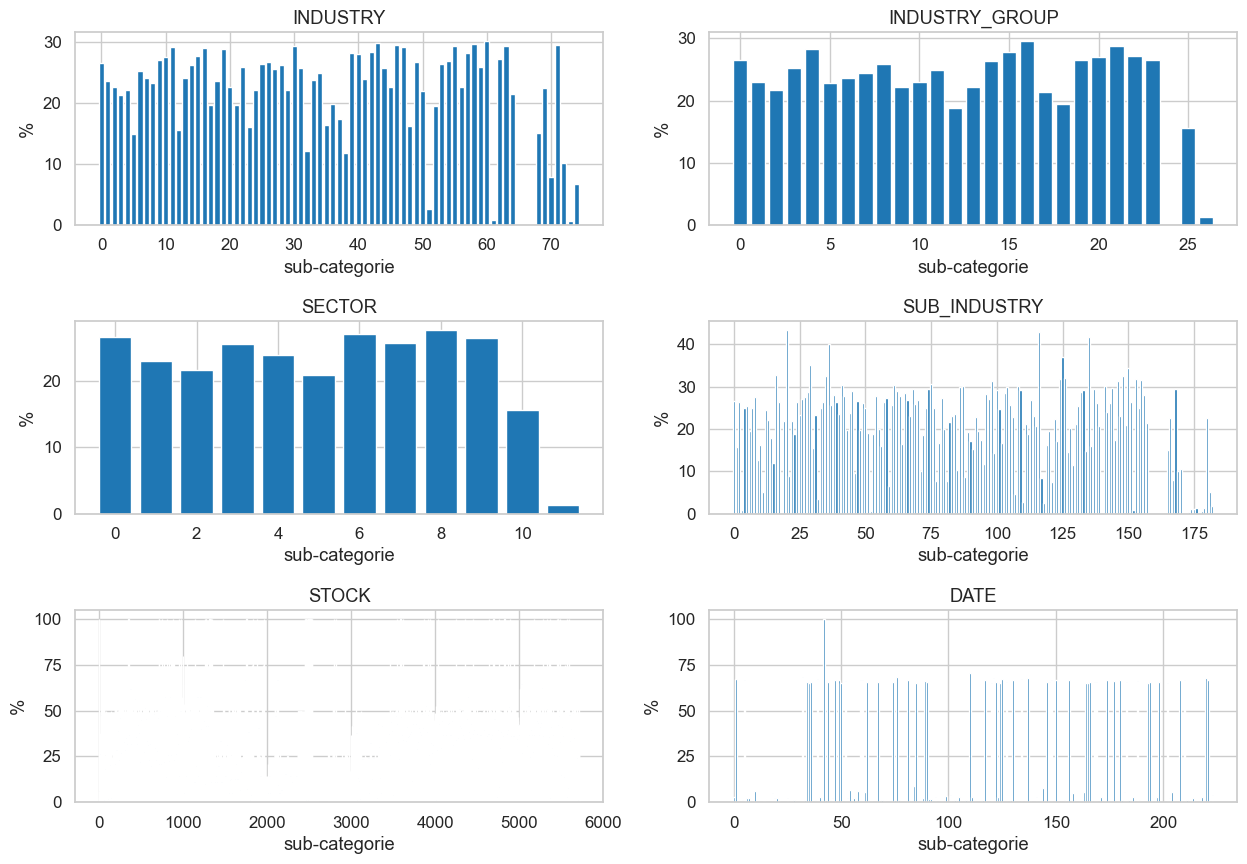

In [8]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)
for i,categorie in enumerate(['INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY', 'STOCK', 'DATE']): 
    plt.subplot(3,2,i+1)
    plt.title(categorie)
    plt.bar(train[categorie].sort_values().unique(),
            [(train[train[categorie]==sub_categorie].isna().sum(axis=1)>0).sum()/len(train[train[categorie]==sub_categorie])*100 for sub_categorie in train[categorie].sort_values().unique()])
    plt.xlabel('sub-categorie')
    plt.ylabel('%')
plt.show()

The plots show the distribution of NaN values per sub-categorie in %. We can see a "fairly" even distribution of NaN values for some categorical variable sectors, whereas #NaN values for the other categorical variables seems less equally spread. It might be interesting to see if there are rows that predominantely consist of NaN values (for the descriptive variables RET and VOLUME). If so, we can drop them since these columns do not add any value in understanding the underlying structure. During this investigation, I noticed the following:

In [9]:
# Check if there exist a row containing mainly NaN values
ret_features = [f'RET_{day}' for day in range(1,6)]
#features += [f'VOLUME_{day}' for day in range(1,21)] # No need to consider VOLUME since it either is there or not
ret_to_drop = train[(train[ret_features].isna().sum(axis=1)/(train[ret_features].shape[1]) >= 1)][ret_features]
ret_to_drop

,RET_1,RET_2,RET_3,RET_4,RET_5
ID,,,,,
2237,NaN,NaN,NaN,NaN,NaN
19916,NaN,NaN,NaN,NaN,NaN
20232,NaN,NaN,NaN,NaN,NaN
27739,NaN,NaN,NaN,NaN,NaN
28578,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
401583,NaN,NaN,NaN,NaN,NaN
401584,NaN,NaN,NaN,NaN,NaN
401585,NaN,NaN,NaN,NaN,NaN


Given no observed returns, there is no volume observed -> only delete those observations where no return has been observed over the past 5 days. I chose a 5 day window since I am using use the observations of the past 5 days in my prediction.

These rows have no recent return history -> uninformative

-> Drop these rows -> Remaining NaNs filled with mean/median

In [10]:
train_clean = train[~all_ret_missing].copy()
print(f"\nBefore: {len(train):,} rows")
print(f"After dropping: {len(train_clean):,} rows ({len(train) - len(train_clean):,} dropped)")


Before: 418,595 rows
After dropping: 416,339 rows (2,256 dropped)


In [14]:
imputer = SimpleImputer(strategy='median')
features_to_impute = ret_cols + vol_cols
train_clean[features_to_impute] = imputer.fit_transform(train_clean[features_to_impute])

remaining_missing = train_clean[features_to_impute].isnull().sum().sum()

## Stationarity Tests

In [15]:
def test_stationarity(series, name):
    """Perform Augmented Dickey-Fuller test for stationarity"""
    result = adfuller(series.dropna(), autolag='AIC')
    return {
        'Feature': name,
        'ADF_Statistic': round(result[0], 4),
        'p_value': round(result[1], 6),
        'Stationary': 'Yes' if result[1] < 0.05 else 'No'
    }

In [20]:
ret_stationarity = []
for i in range(1, 21):
    col = f'RET_{i}'
    ts = train_clean.groupby('DATE')[col].mean().fillna(0)
    result = test_stationarity(ts, col)
    ret_stationarity.append(result)

ret_stat_df = pd.DataFrame(ret_stationarity)
stationary_ret = (ret_stat_df['Stationary'] == 'Yes').sum()
print(f"Stationary: {stationary_ret}/20")

Stationary: 20/20


All returns stationary -> Use in levels, no differencing needed

In [22]:
vol_stationarity = []
for i in range(1, 21):
    col = f'VOLUME_{i}'
    ts = train_clean.groupby('DATE')[col].mean().fillna(0)
    result = test_stationarity(ts, col)
    vol_stationarity.append(result)

vol_stat_df = pd.DataFrame(vol_stationarity)
stationary_vol = (vol_stat_df['Stationary'] == 'Yes').sum()
print(f"Stationary: {stationary_vol}/20")

Stationary: 20/20


All volume stationary -> Safe to use directly

## Distribution Analysis

In [23]:
ret_stats = train_clean[ret_cols].describe().T
ret_stats['skewness'] = train_clean[ret_cols].skew()
ret_stats['kurtosis'] = train_clean[ret_cols].kurtosis()

print("RETURNS: Summary Statistics (first 5 lags)")
print("-"*60)
print(ret_stats[['mean', 'std', 'skewness', 'kurtosis']].head().round(4))


RETURNS: Summary Statistics (first 5 lags)
------------------------------------------------------------
         mean     std  skewness  kurtosis
RET_1  0.0014  0.0313    1.9722   78.1635
RET_2  0.0010  0.0310    1.2577   49.5815
RET_3  0.0022  0.0313    3.5411  277.1406
RET_4 -0.0007  0.0312    1.8376  118.1477
RET_5  0.0004  0.0319    2.1169   77.0450


In [25]:
vol_stats = train_clean[vol_cols].describe().T
vol_stats['skewness'] = train_clean[vol_cols].skew()
vol_stats['kurtosis'] = train_clean[vol_cols].kurtosis()
print(vol_stats[['mean', 'std', 'skewness', 'kurtosis']].head().round(4))

            mean     std  skewness    kurtosis
VOLUME_1 -0.1033  2.8013  249.3815  96757.8611
VOLUME_2 -0.1065  2.4252  149.2733  33031.6182
VOLUME_3 -0.1257  2.2873  223.2669  78951.2455
VOLUME_4 -0.1198  1.5830   89.1768  18041.7072
VOLUME_5 -0.1251  1.6820   90.8865  17603.7753


## Correlation with Target

In [27]:
train_clean['RET_numeric'] = train_clean['RET'].astype(int)
ret_target_corr = train_clean[ret_cols].corrwith(train_clean['RET_numeric'])
print(f"RET_1 correlation: {ret_target_corr.iloc[0]:.4f} (highest)")
print(f"RET_5 correlation: {ret_target_corr.iloc[4]:.4f}")
print(f"RET_20 correlation: {ret_target_corr.iloc[19]:.4f} (lowest)")

RET_1 correlation: -0.0168 (highest)
RET_5 correlation: 0.0031
RET_20 correlation: -0.0032 (lowest)


In [28]:
vol_target_corr = train_clean[vol_cols].corrwith(train_clean['RET_numeric'])
print("\n" + "-"*60)
print("VOLUMES ↔ TARGET:")
print("-"*60)
print(f"Mean |correlation|: {vol_target_corr.abs().mean():.4f}")
print(f"Max |correlation|: {vol_target_corr.abs().max():.4f}")


------------------------------------------------------------
VOLUMES ↔ TARGET:
------------------------------------------------------------
Mean |correlation|: 0.0014
Max |correlation|: 0.0046


## Variance Decomposition

In [30]:
def compute_icc(data, target_col, group_col):
    """Compute Intra-Class Correlation (ICC)"""
    group_means = data.groupby(group_col)[target_col].mean()
    overall_mean = data[target_col].mean()
    group_sizes = data.groupby(group_col).size()

    var_between = ((group_means - overall_mean) ** 2 * group_sizes).sum() / (len(group_means) - 1)
    var_within = data.groupby(group_col)[target_col].var().mean()
    icc = var_between / (var_between + var_within)

    return icc * 100

icc_results = []
for cat in ['SECTOR', 'INDUSTRY', 'INDUSTRY_GROUP', 'SUB_INDUSTRY']:
    icc = compute_icc(train_clean, 'RET_numeric', cat)
    print(f"{cat:20s}: {icc:.2f}%")
    icc_results.append(icc)

avg_icc = np.mean(icc_results)
print(f"\nAverage ICC: {avg_icc:.2f}%")


SECTOR              : 90.77%
INDUSTRY            : 85.26%
INDUSTRY_GROUP      : 89.81%
SUB_INDUSTRY        : 78.98%

Average ICC: 86.20%


## Correlation Matrices

In [34]:
ret_corr = train_clean[ret_cols].corr()
print("RETURNS: Correlation Structure")
print("-"*60)
print(f"Mean absolute correlation: {ret_corr.abs().mean().mean():.4f}")
print(f"Max off-diagonal correlation: {ret_corr.where(~np.eye(20, dtype=bool)).abs().max().max():.4f}")

adjacent_corrs = [ret_corr.iloc[i, i+1] for i in range(19)]
print(f"\nAdjacent lag correlations (RET_i vs RET_{i+1}):")
print(f"  Mean: {np.mean(adjacent_corrs):.4f}")
print(f"  Range: [{min(adjacent_corrs):.4f}, {max(adjacent_corrs):.4f}]")

vol_corr = train_clean[vol_cols].corr()
print(f"Mean absolute correlation: {vol_corr.abs().mean().mean():.4f}")
print(f"Max off-diagonal correlation: {vol_corr.where(~np.eye(20, dtype=bool)).abs().max().max():.4f}")

cross_corr = pd.DataFrame(index=ret_cols, columns=vol_cols, dtype=float)
for ret in ret_cols:
    for vol in vol_cols:
        cross_corr.loc[ret, vol] = train_clean[ret].corr(train_clean[vol])
print(f"Mean absolute cross-correlation: {cross_corr.abs().mean().mean():.4f}")
print(f"Max cross-correlation: {cross_corr.abs().max().max():.4f}")

RETURNS: Correlation Structure
------------------------------------------------------------
Mean absolute correlation: 0.0785
Max off-diagonal correlation: 0.1327

Adjacent lag correlations (RET_i vs RET_21):
  Mean: -0.0202
  Range: [-0.1327, 0.0543]
Mean absolute correlation: 0.1226
Max off-diagonal correlation: 0.4721
Mean absolute cross-correlation: 0.0125
Max cross-correlation: 0.1944


## Feature Engineering Hypotheses

## Statistics 

# Correlation

## EDA

Good news: 
- Balanced target: 50/50 split
- No data leakage: Future lags (-2, -1) show ~0 correlation with target
- Reasonable size: 418k train samples over 224 days (~1,870 stocks/day)
- Signal exists: RET_1 has -0.0168 correlation (small but real for cross-sectional equity)

Issues:
- High volume missing: ~18% missing in VOLUME features (74k/418k)
- Date encoding: Dates are integers (0-223), not timestamps—fine for splitting

In [4]:
print("=== TRAIN DATA OVERVIEW ===")
print(f"Shape: {train.shape}")
print(f"Date range: {train['DATE'].min()} to {train['DATE'].max()}")
print(f"\nMissing values:\n{train.isnull().sum().sort_values(ascending=False).head(10)}")
print(f"\nTarget distribution:\n{train['RET'].value_counts(normalize=True)}")

=== TRAIN DATA OVERVIEW ===
Shape: (418595, 47)
Date range: 0 to 223

Missing values:
VOLUME_6     74714
VOLUME_5     74693
VOLUME_8     73898
VOLUME_7     73853
VOLUME_10    73305
VOLUME_9     73298
VOLUME_11    72025
VOLUME_4     70997
VOLUME_20    67857
VOLUME_3     67819
dtype: int64

Target distribution:
RET
False    0.501079
True     0.498921
Name: proportion, dtype: float64


In [5]:
print("=== TEST DATA OVERVIEW ===")
print(f"Shape: {test.shape}")
print(f"Date range: {test['DATE'].min()} to {test['DATE'].max()}")
print(f"\nMissing values:\n{test.isnull().sum().sort_values(ascending=False).head(10)}")

=== TEST DATA OVERVIEW ===
Shape: (198429, 46)
Date range: 2 to 222

Missing values:
VOLUME_19    32133
VOLUME_9     31128
VOLUME_8     31120
VOLUME_7     31109
VOLUME_6     31102
VOLUME_5     31095
VOLUME_10    29253
VOLUME_4     29199
VOLUME_15    28934
VOLUME_14    28613
dtype: int64


In [8]:
# For categorical columns (the ID-like columns)
categorical_cols = ['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY']
print("\nUnique values in categorical columns:")
for col in categorical_cols:
    print(f"{col}: {train[col].nunique()} unique values")


Unique values in categorical columns:
DATE: 156 unique values
STOCK: 5350 unique values
INDUSTRY: 72 unique values
INDUSTRY_GROUP: 26 unique values
SECTOR: 12 unique values
SUB_INDUSTRY: 175 unique values



2. MISSING VALUES ANALYSIS
           Missing Values  Percentage
VOLUME_6            74714   17.848756
VOLUME_5            74693   17.843739
VOLUME_8            73898   17.653818
VOLUME_7            73853   17.643068
VOLUME_10           73305   17.512154
VOLUME_9            73298   17.510481
VOLUME_11           72025   17.206369
VOLUME_4            70997   16.960785
VOLUME_20           67857   16.210657
VOLUME_3            67819   16.201579
VOLUME_18           67586   16.145917
VOLUME_19           67329   16.084521
VOLUME_16           67262   16.068515
VOLUME_2            66386   15.859243
VOLUME_15           66373   15.856138
VOLUME_1            65025   15.534108
VOLUME_12           62523   14.936394
VOLUME_17           62314   14.886465
VOLUME_14           60929   14.555597
VOLUME_13           59008   14.096681
RET_20               5341    1.275935
RET_19               5313    1.269246
RET_18               5307    1.267813
RET_17               5301    1.266379
RET_16               5

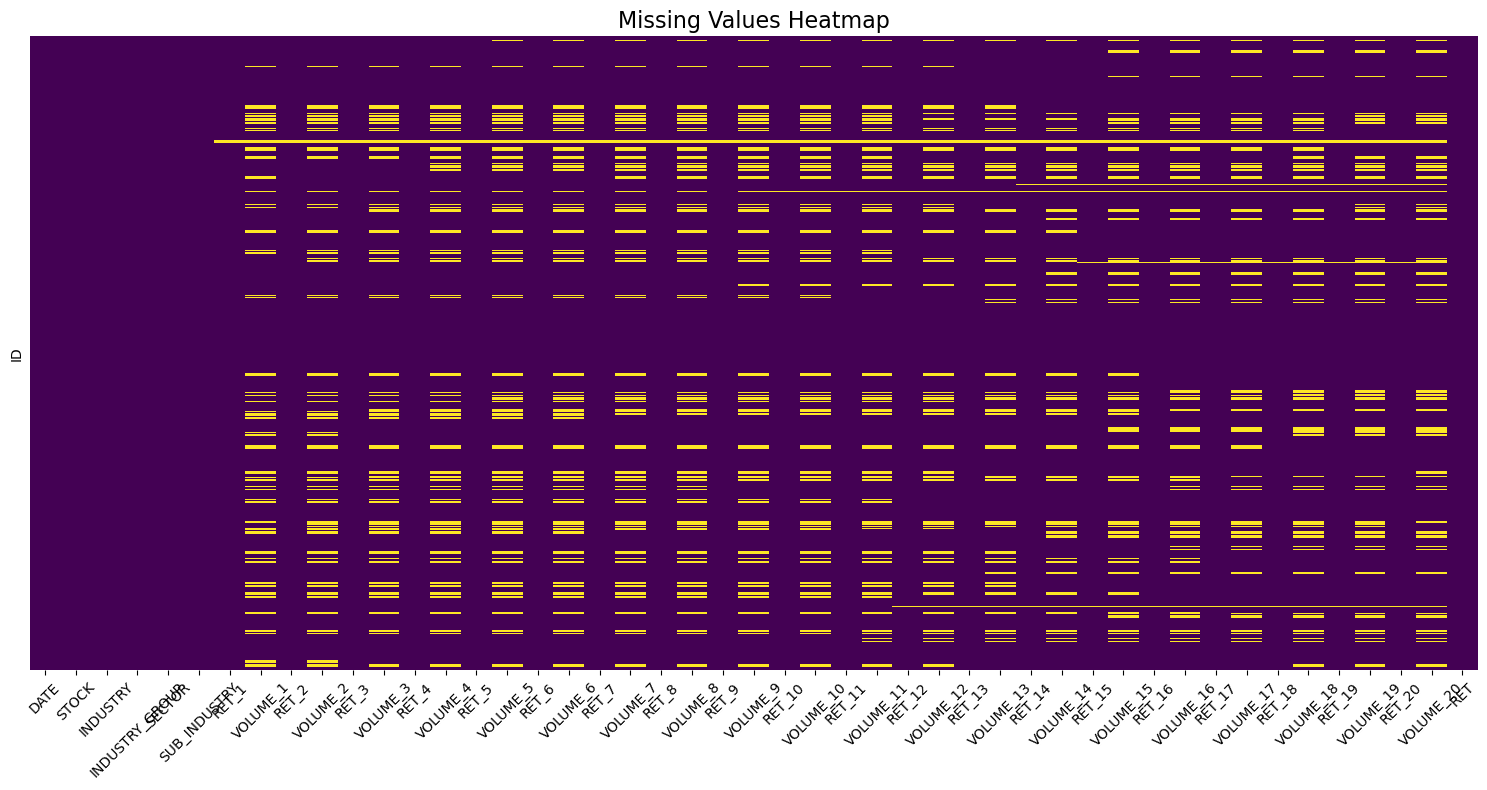

In [9]:
# 2. MISSING VALUES ANALYSIS
print("\n" + "="*50)
print("2. MISSING VALUES ANALYSIS")
print("="*50)
missing_values = train.isnull().sum()
missing_percentage = (missing_values / len(train)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})
print(missing_df[missing_df['Missing Values'] > 0].sort_values('Percentage', ascending=False))


3. TARGET VARIABLE ANALYSIS
Target variable 'RET' distribution:
RET
False    209749
True     208846
Name: count, dtype: int64

Percentage distribution:
RET
False    50.107861
True     49.892139
Name: proportion, dtype: float64


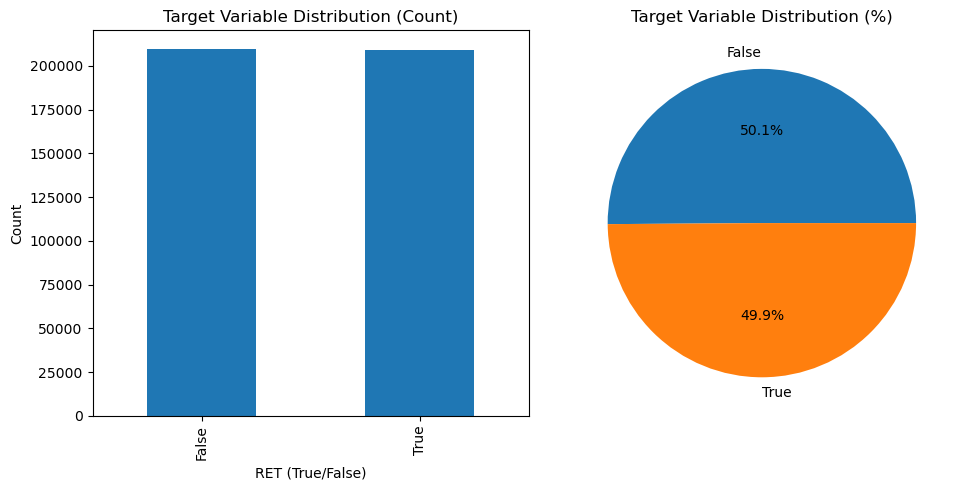

In [11]:
# 3. TARGET VARIABLE ANALYSIS
print("\n" + "="*50)
print("3. TARGET VARIABLE ANALYSIS")
print("="*50)
print(f"Target variable 'RET' distribution:")
print(train['RET'].value_counts())
print(f"\nPercentage distribution:")
print(train['RET'].value_counts(normalize=True) * 100)

# Visualize target distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
train['RET'].value_counts().plot(kind='bar')
plt.title('Target Variable Distribution (Count)')
plt.xlabel('RET (True/False)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
train['RET'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%')
plt.title('Target Variable Distribution (%)')
plt.ylabel('')
plt.tight_layout()
plt.show()


4. CORRELATION ANALYSIS

Correlation of return features with target:
   Feature  Correlation_with_Target
0    RET_1                -0.016845
16  RET_17                -0.014077
15  RET_16                -0.012448
1    RET_2                -0.009127
7    RET_8                -0.008396
12  RET_13                -0.005953
6    RET_7                 0.005828
9   RET_10                 0.005371
3    RET_4                -0.005003
8    RET_9                -0.004244


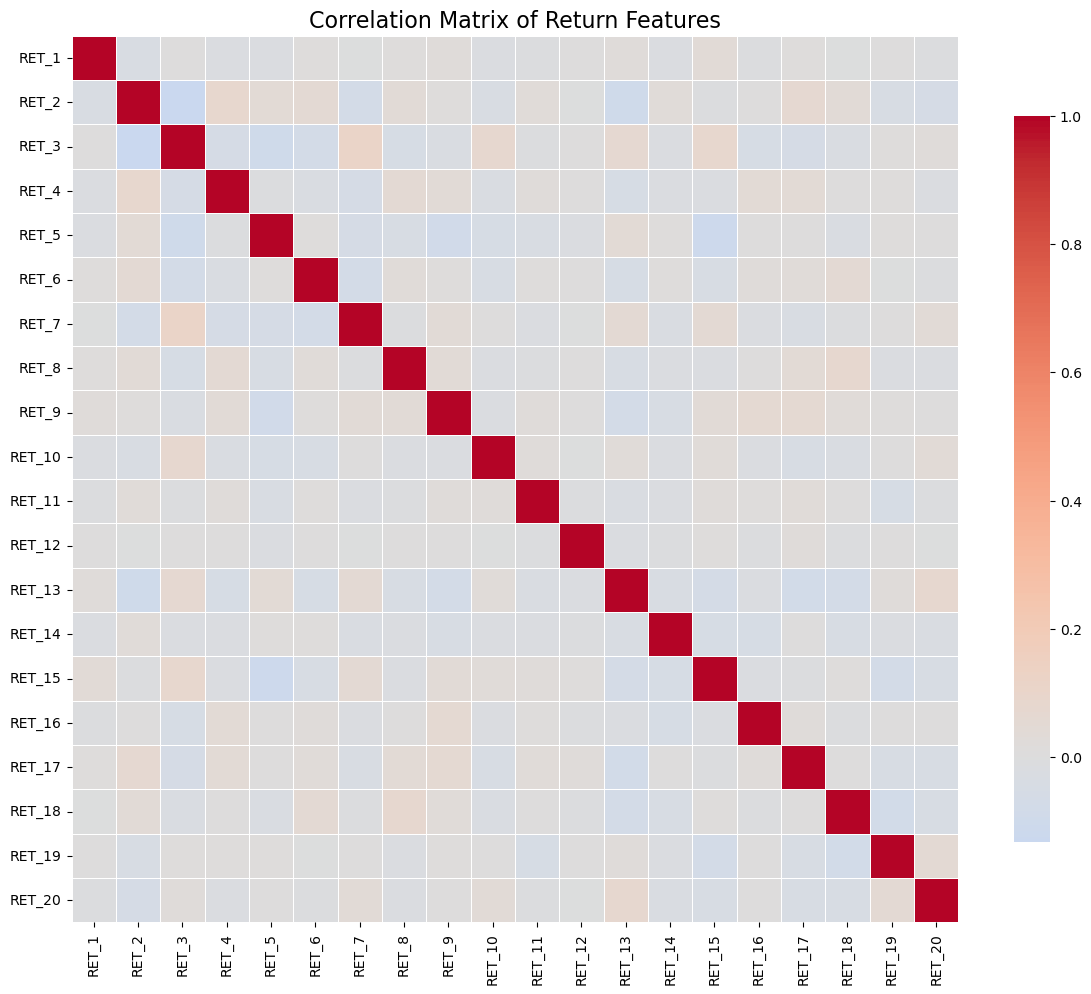

In [12]:
print("\n" + "="*50)
print("4. CORRELATION ANALYSIS")
print("="*50)

# Get all return columns
return_cols = [col for col in train.columns if col.startswith('RET_')]
volume_cols = [col for col in train.columns if col.startswith('VOLUME_')]

# Correlation between returns and target
correlations = []
for ret_col in return_cols:
    corr = train[ret_col].corr(train['RET'].astype(int))
    correlations.append((ret_col, corr))

corr_df = pd.DataFrame(correlations, columns=['Feature', 'Correlation_with_Target'])
print("\nCorrelation of return features with target:")
print(corr_df.sort_values('Correlation_with_Target', key=abs, ascending=False).head(10))

# Correlation matrix for returns
plt.figure(figsize=(12, 10))
return_data = train[return_cols]
corr_matrix = return_data.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Return Features', fontsize=16)
plt.tight_layout()
plt.show()


5. TIME SERIES ANALYSIS


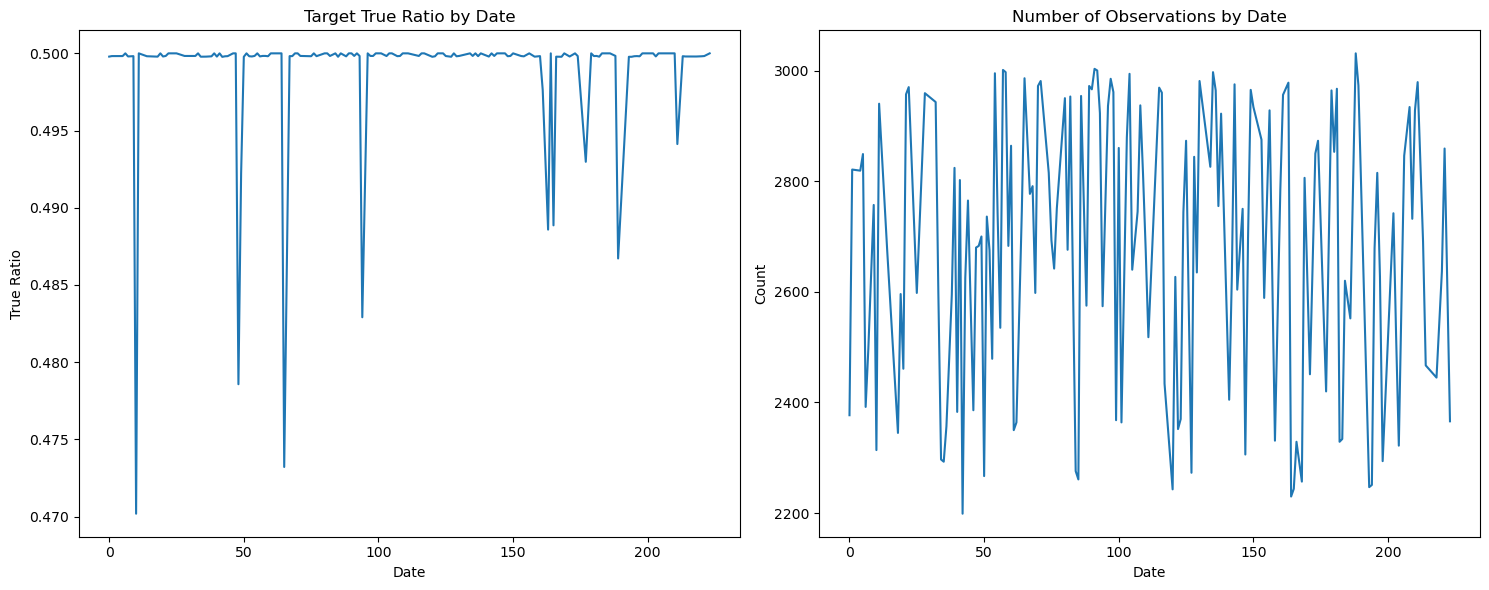

In [13]:
# 5. TIME SERIES ANALYSIS
print("\n" + "="*50)
print("5. TIME SERIES ANALYSIS")
print("="*50)

# Check target distribution over time
if 'DATE' in train.columns:
    plt.figure(figsize=(15, 6))
    
    # Plot 1: Target distribution by date
    plt.subplot(1, 2, 1)
    date_target_ratio = train.groupby('DATE')['RET'].mean()
    date_target_ratio.plot()
    plt.title('Target True Ratio by Date')
    plt.xlabel('Date')
    plt.ylabel('True Ratio')
    
    # Plot 2: Number of observations by date
    plt.subplot(1, 2, 2)
    date_counts = train['DATE'].value_counts().sort_index()
    date_counts.plot()
    plt.title('Number of Observations by Date')
    plt.xlabel('Date')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()


6. DISTRIBUTION ANALYSIS


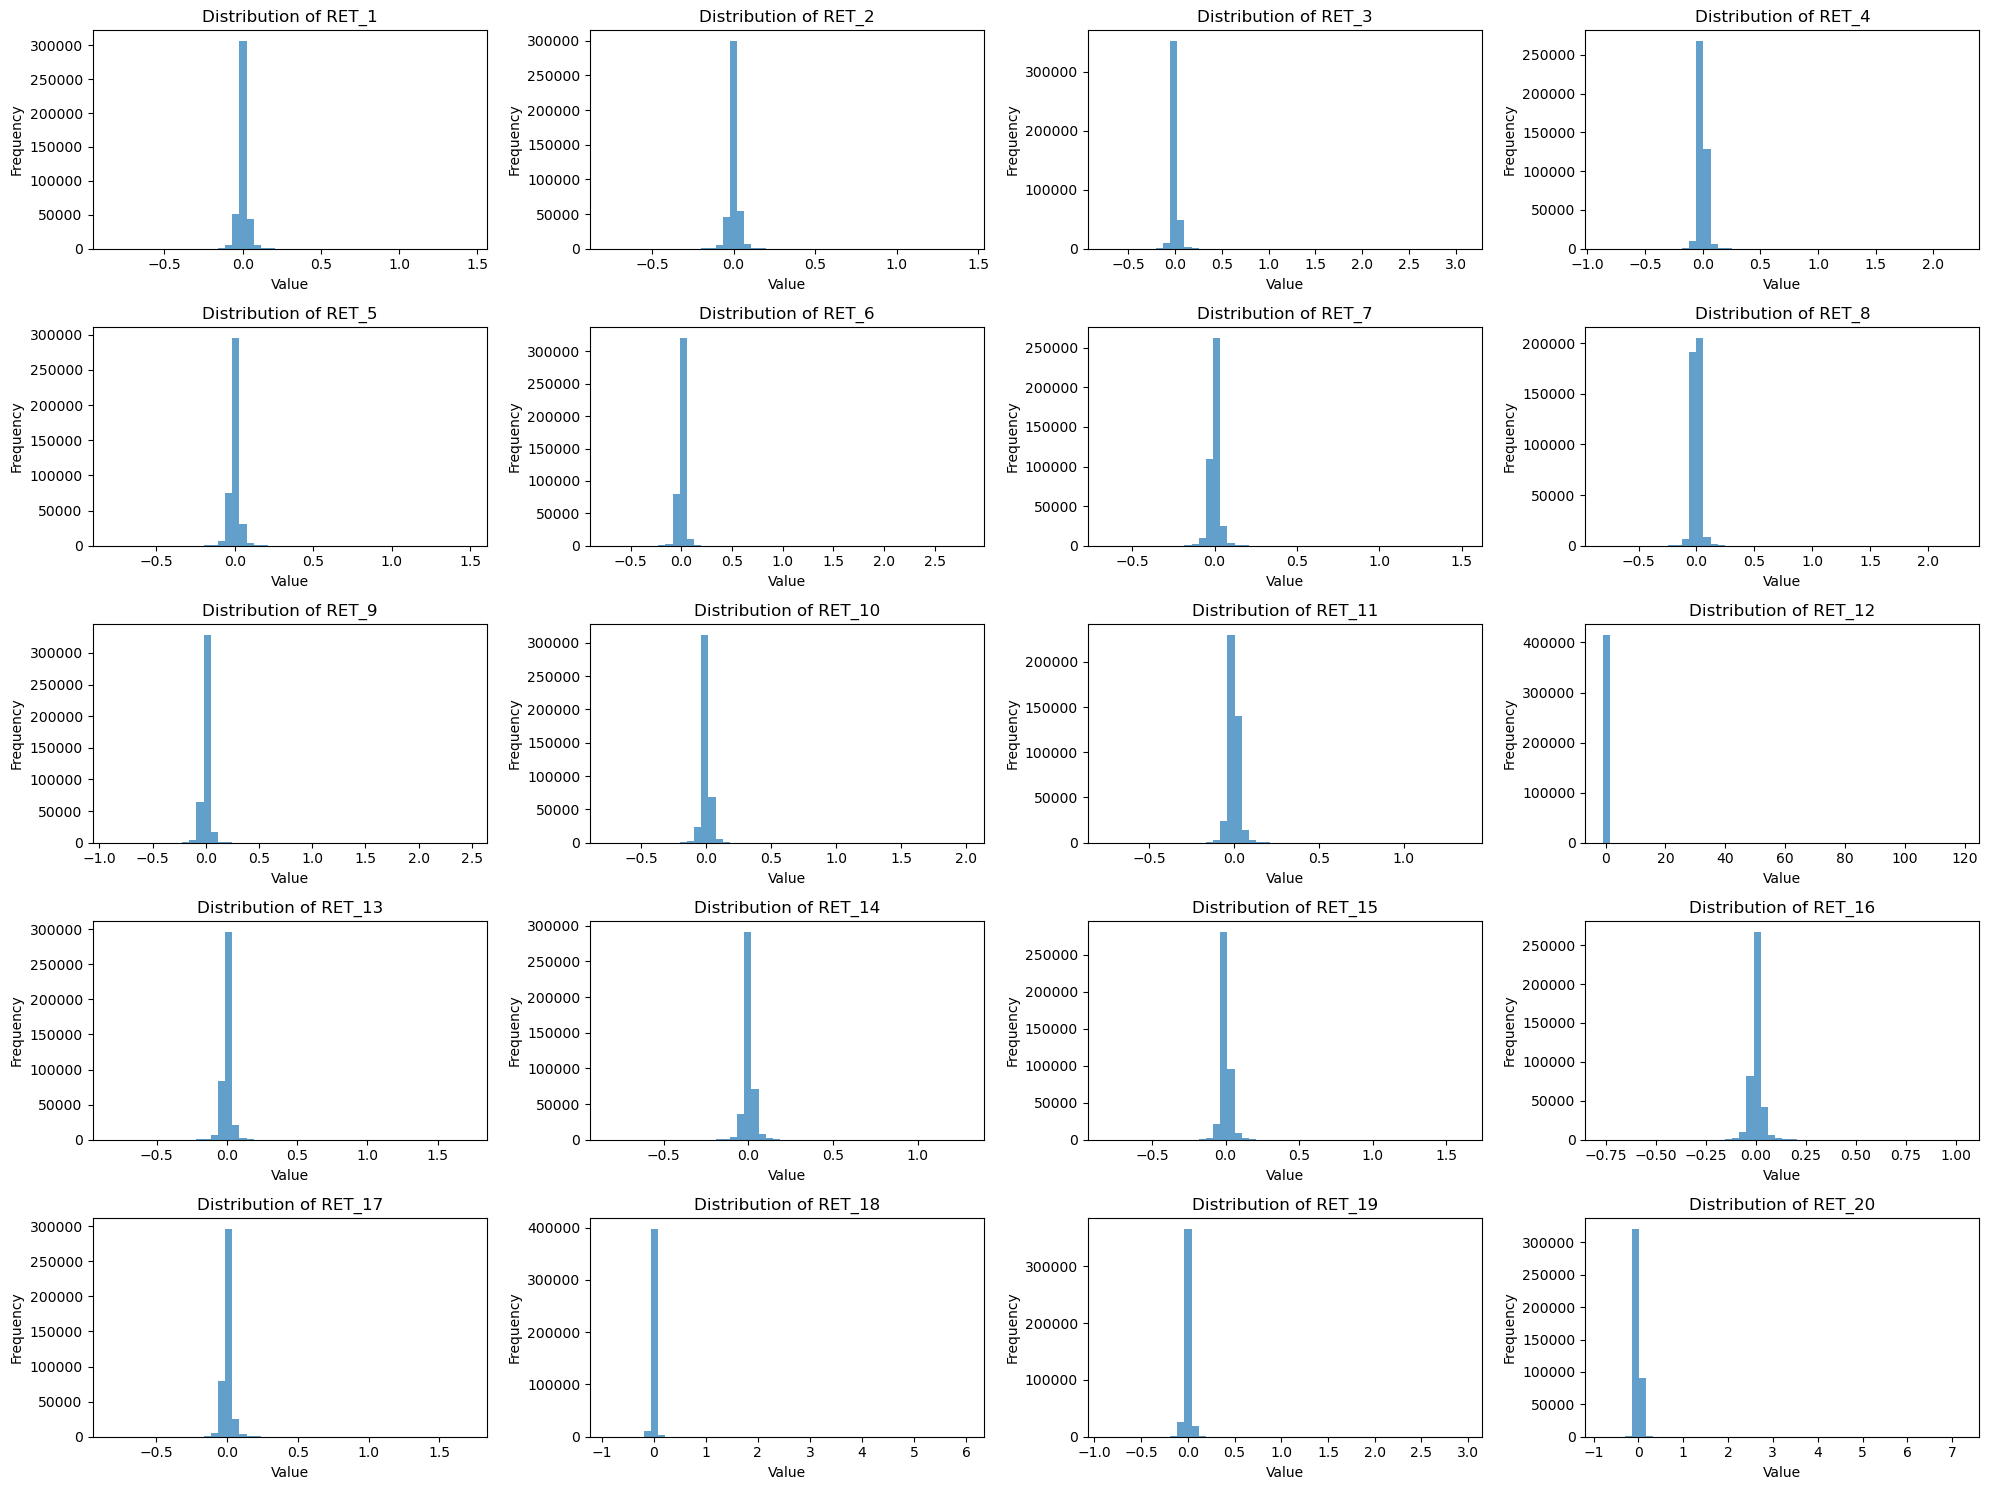

In [14]:
print("\n" + "="*50)
print("6. DISTRIBUTION ANALYSIS")
print("="*50)

# Analyze distribution of returns
fig, axes = plt.subplots(5, 4, figsize=(20, 15))
axes = axes.flatten()

for idx, ret_col in enumerate(return_cols[:20]):
    axes[idx].hist(train[ret_col].dropna(), bins=50, alpha=0.7)
    axes[idx].set_title(f'Distribution of {ret_col}')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [16]:
print("\n" + "="*50)
print("7. FEATURE ENGINEERING INSIGHTS")
print("="*50)

# Calculate rolling statistics for returns
for window in [5, 10, 20]:
    rolling_mean_col = f'RET_MEAN_{window}'
    rolling_std_col = f'RET_STD_{window}'
    
    # Example: Calculate rolling statistics for each stock-date combination
    print(f"\nWindow {window} statistics would provide:")
    print(f"- {rolling_mean_col}: Rolling mean of returns")
    print(f"- {rolling_std_col}: Rolling volatility")



7. FEATURE ENGINEERING INSIGHTS

Window 5 statistics would provide:
- RET_MEAN_5: Rolling mean of returns
- RET_STD_5: Rolling volatility

Window 10 statistics would provide:
- RET_MEAN_10: Rolling mean of returns
- RET_STD_10: Rolling volatility

Window 20 statistics would provide:
- RET_MEAN_20: Rolling mean of returns
- RET_STD_20: Rolling volatility



8. CATEGORICAL VARIABLE ANALYSIS


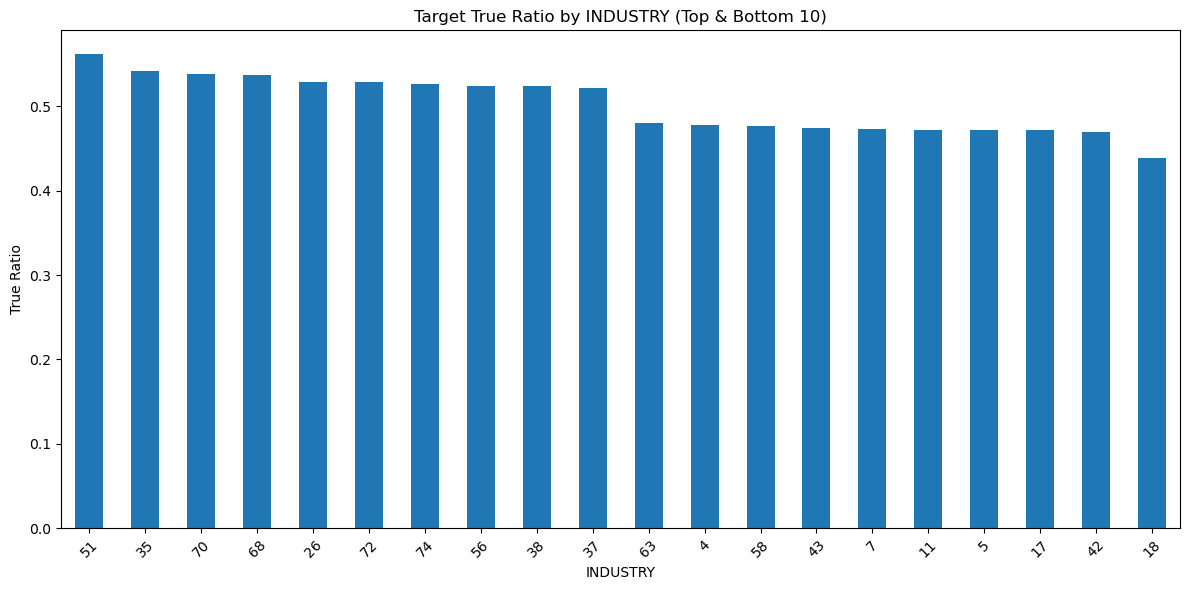

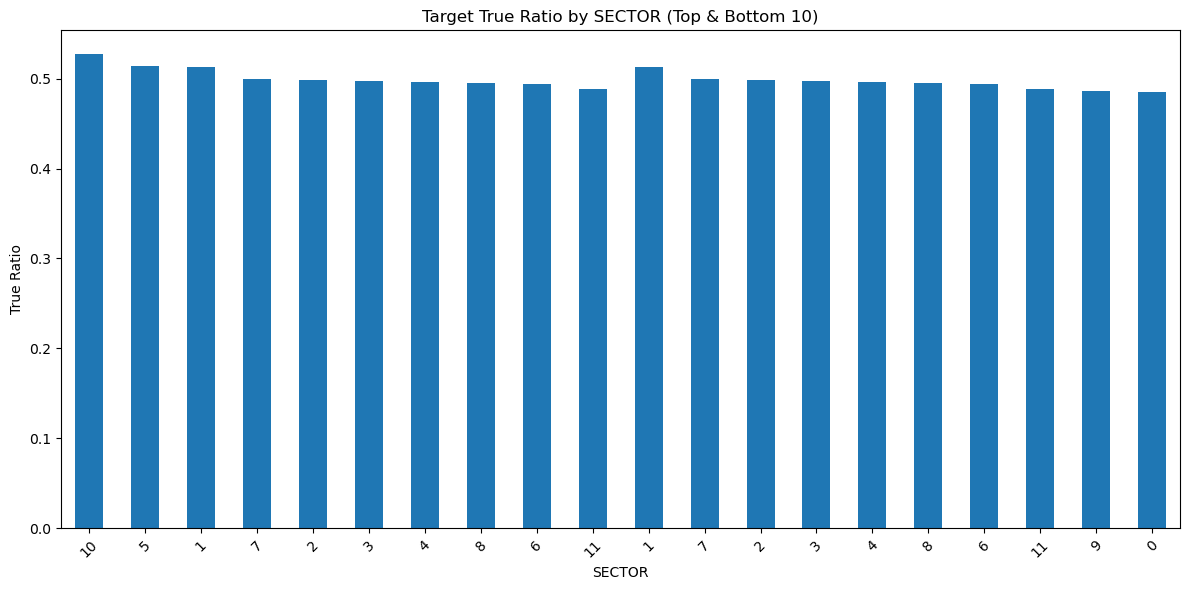

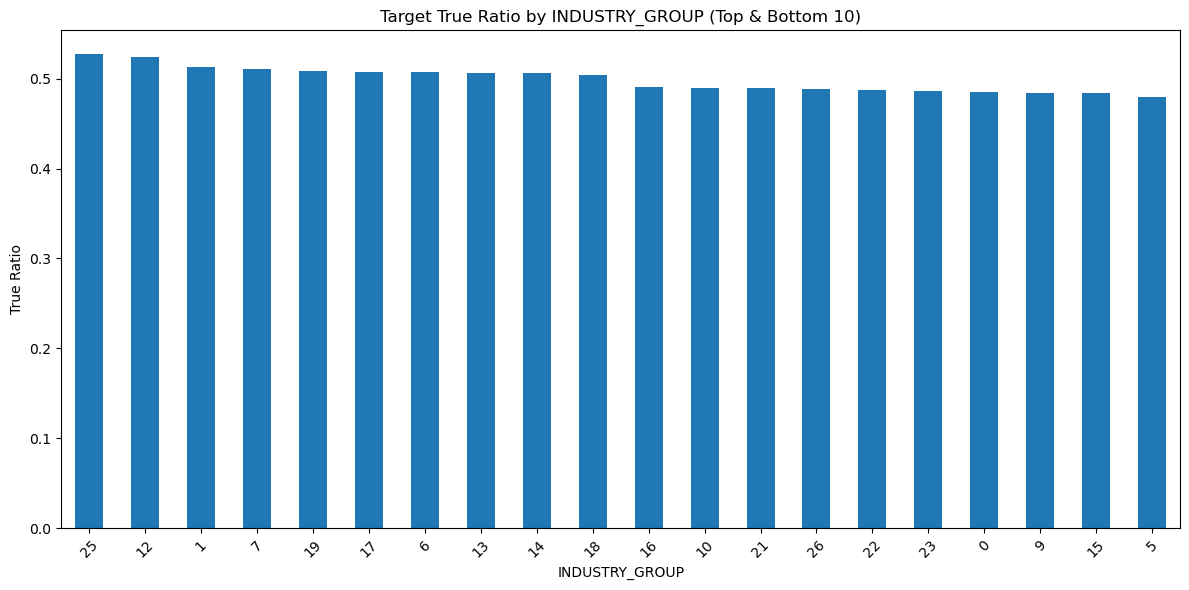

In [17]:
# 8. CATEGORICAL VARIABLE ANALYSIS
print("\n" + "="*50)
print("8. CATEGORICAL VARIABLE ANALYSIS")
print("="*50)

# Analyze target distribution across industries
for cat_col in ['INDUSTRY', 'SECTOR', 'INDUSTRY_GROUP']:
    if cat_col in train.columns:
        plt.figure(figsize=(12, 6))
        industry_ret = train.groupby(cat_col)['RET'].mean().sort_values(ascending=False)
        
        # Take top and bottom 10 for visualization
        top_bottom = pd.concat([industry_ret.head(10), industry_ret.tail(10)])
        top_bottom.plot(kind='bar')
        plt.title(f'Target True Ratio by {cat_col} (Top & Bottom 10)')
        plt.xlabel(cat_col)
        plt.ylabel('True Ratio')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


In [18]:
print("\n" + "="*50)
print("9. OUTLIER DETECTION")
print("="*50)

# Check for outliers in returns using IQR method
for ret_col in return_cols[:5]:  # Check first 5 return columns
    Q1 = train[ret_col].quantile(0.25)
    Q3 = train[ret_col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = ((train[ret_col] < lower_bound) | (train[ret_col] > upper_bound)).sum()
    print(f"{ret_col}: {outliers} outliers ({outliers/len(train)*100:.2f}%)")


9. OUTLIER DETECTION
RET_1: 32030 outliers (7.65%)
RET_2: 33602 outliers (8.03%)
RET_3: 35243 outliers (8.42%)
RET_4: 33085 outliers (7.90%)
RET_5: 32590 outliers (7.79%)



10. PAIRWISE RELATIONSHIPS


<Figure size 1500x1200 with 0 Axes>

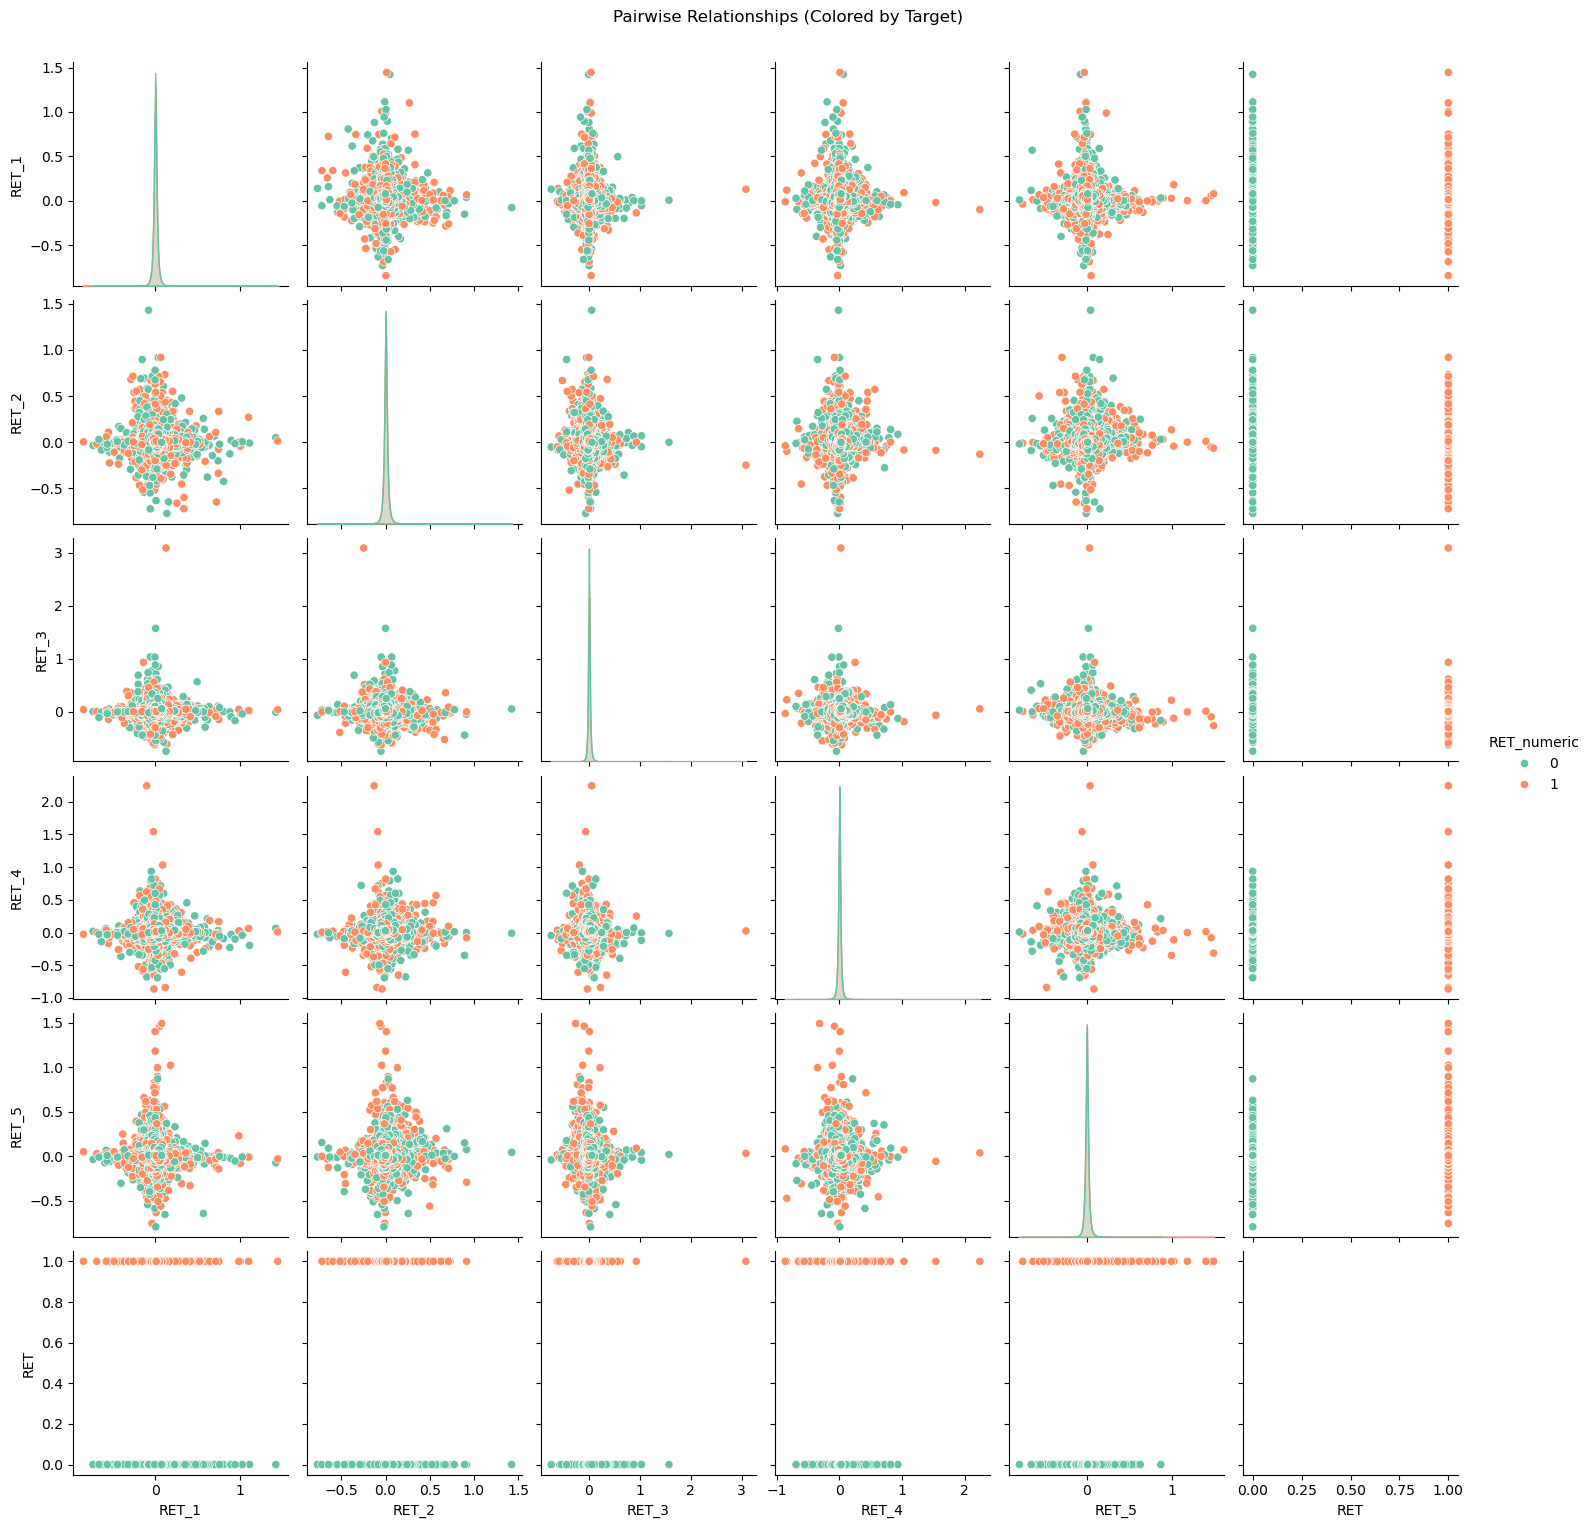

In [19]:
print("\n" + "="*50)
print("10. PAIRWISE RELATIONSHIPS")
print("="*50)

# Scatter plots for selected return pairs
selected_returns = return_cols[:5] + ['RET']  # First 5 returns + target

# Convert target to numeric for plotting
train_numeric = train.copy()
train_numeric['RET_numeric'] = train['RET'].astype(int)

plt.figure(figsize=(15, 12))
sns.pairplot(train_numeric[selected_returns + ['RET_numeric']].dropna(), 
             hue='RET_numeric', palette='Set2', diag_kind='kde')
plt.suptitle('Pairwise Relationships (Colored by Target)', y=1.02)
plt.show()



11. VOLUME-RETURN RELATIONSHIP


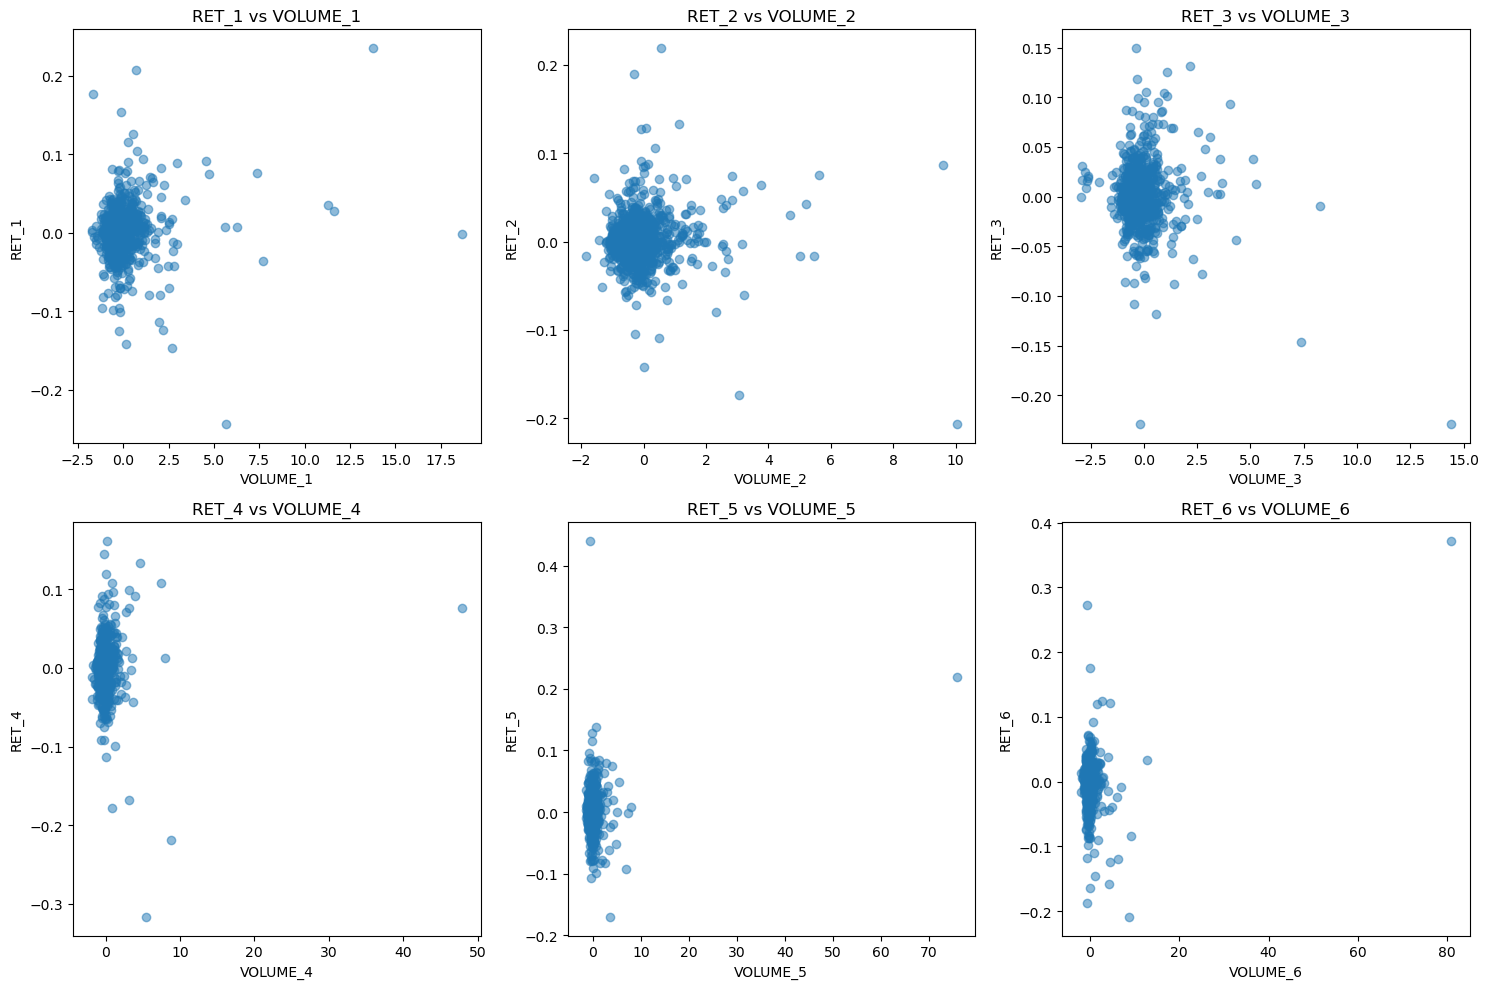

In [20]:
print("\n" + "="*50)
print("11. VOLUME-RETURN RELATIONSHIP")
print("="*50)

# Analyze relationship between volume and returns for first few lags
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(6):
    ret_col = f'RET_{i+1}'
    vol_col = f'VOLUME_{i+1}'
    
    if ret_col in train.columns and vol_col in train.columns:
        sample_data = train[[ret_col, vol_col]].dropna().sample(1000)  # Sample for performance
        axes[i].scatter(sample_data[vol_col], sample_data[ret_col], alpha=0.5)
        axes[i].set_title(f'{ret_col} vs {vol_col}')
        axes[i].set_xlabel(vol_col)
        axes[i].set_ylabel(ret_col)

plt.tight_layout()
plt.show()



12. AUTOCORRELATION ANALYSIS


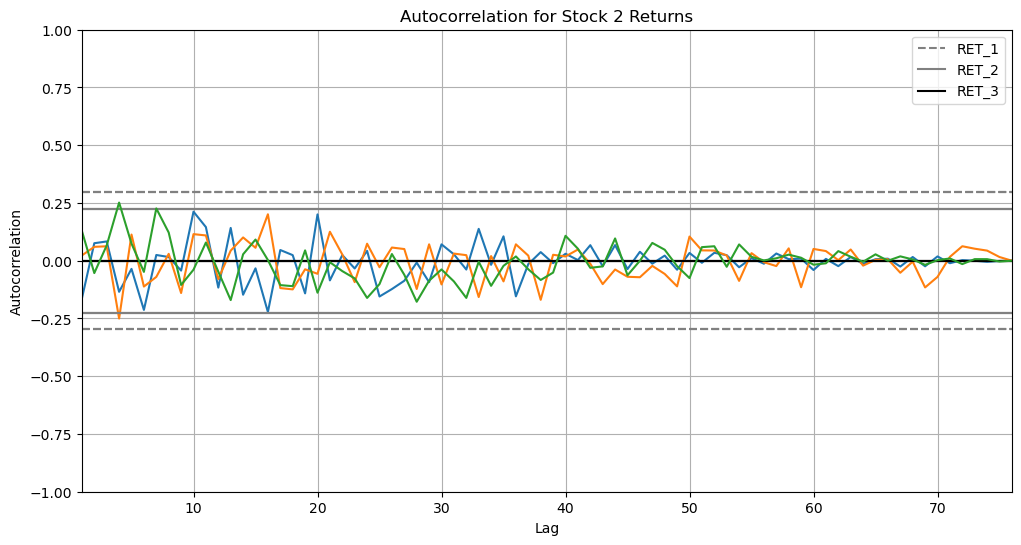

In [21]:
print("\n" + "="*50)
print("12. AUTOCORRELATION ANALYSIS")
print("="*50)

# Check autocorrelation in returns for individual stocks
sample_stock = train['STOCK'].iloc[0]  # Take first stock as example
stock_data = train[train['STOCK'] == sample_stock]

if len(stock_data) > 10:
    from pandas.plotting import autocorrelation_plot
    
    plt.figure(figsize=(12, 6))
    for ret_col in return_cols[:3]:  # First 3 return columns
        if ret_col in stock_data.columns:
            autocorrelation_plot(stock_data[ret_col].dropna())
    plt.title(f'Autocorrelation for Stock {sample_stock} Returns')
    plt.legend(return_cols[:3])
    plt.show()

In [22]:
print("\n" + "="*50)
print("13. CROSS-TABULATION ANALYSIS")
print("="*50)

# Create cross-tab between industry and target
if 'INDUSTRY' in train.columns:
    cross_tab = pd.crosstab(train['INDUSTRY'], train['RET'], normalize='index')
    print("\nIndustry vs Target (Normalized by row):")
    print(cross_tab.head(10))



13. CROSS-TABULATION ANALYSIS

Industry vs Target (Normalized by row):
RET          False     True 
INDUSTRY                    
0         0.514753  0.485247
1         0.494613  0.505387
2         0.482521  0.517479
3         0.483941  0.516059
4         0.522680  0.477320
5         0.528519  0.471481
6         0.505288  0.494712
7         0.527423  0.472577
8         0.508099  0.491901
9         0.500153  0.499847



14. FEATURE IMPORTANCE (Quick Test)

Top 20 Most Important Features:
   feature  importance
6    RET_7    0.028003
10  RET_11    0.027583
4    RET_5    0.027580
15  RET_16    0.027487
16  RET_17    0.027472
0    RET_1    0.027459
14  RET_15    0.027251
9   RET_10    0.027198
11  RET_12    0.027115
2    RET_3    0.027062
5    RET_6    0.027013
7    RET_8    0.026969
3    RET_4    0.026924
13  RET_14    0.026913
19  RET_20    0.026765
12  RET_13    0.026634
18  RET_19    0.026633
8    RET_9    0.026624
1    RET_2    0.026134
17  RET_18    0.026103


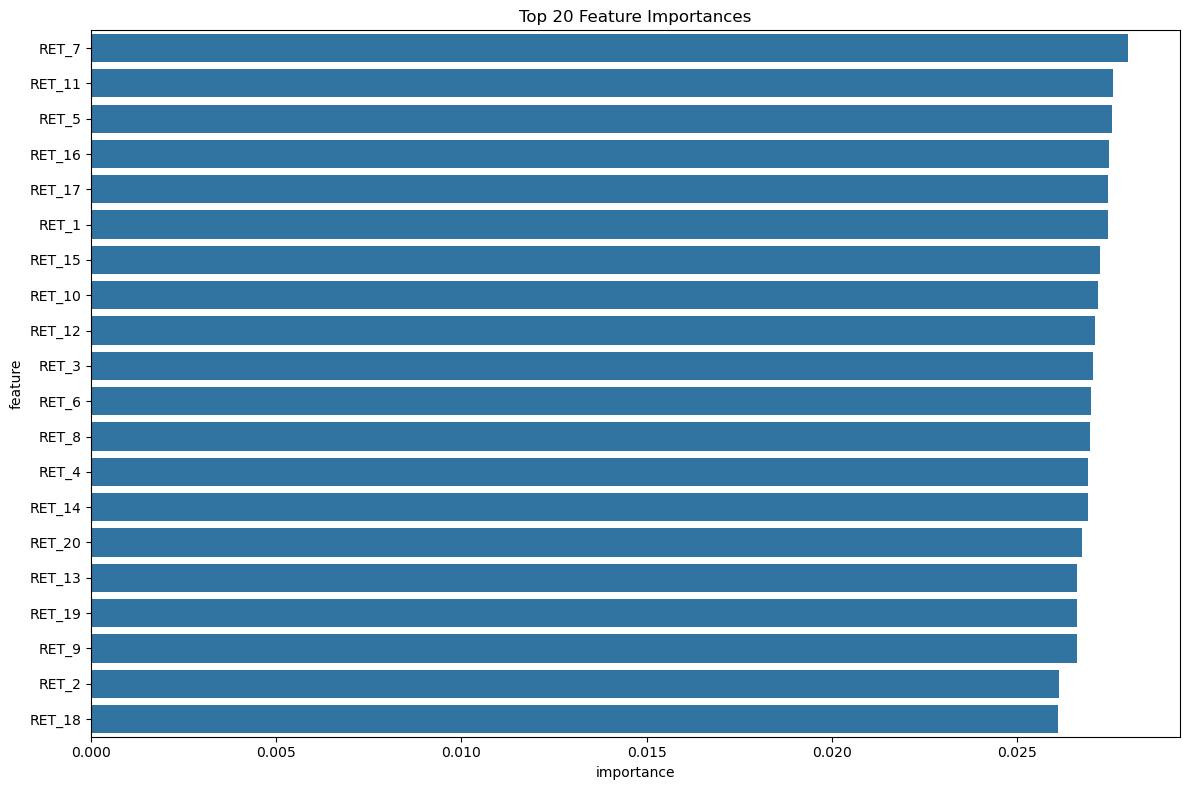

In [23]:
print("\n" + "="*50)
print("14. FEATURE IMPORTANCE (Quick Test)")
print("="*50)

# Prepare data for feature importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Select features and target
features = return_cols + volume_cols
X = train[features].fillna(train[features].median())
y = train['RET']

# Take a sample for quicker computation
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=0.1, random_state=42, stratify=y)

# Train a quick Random Forest
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf.fit(X_sample, y_sample)

# Get feature importance
importance_df = pd.DataFrame({
    'feature': features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(importance_df.head(20))

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

### Data Leakage

In [6]:
# Check for data leakage - correlation of features with target at different lags
print("\n=== CHECKING FOR TRAIN DATA LEAKAGE ===")
feature_cols = [col for col in train.columns if col.startswith('RET_') or col.startswith('VOLUME_')]
leak_check = []
for col in feature_cols[:5]:  # Check first 5 features as example
    for lag in range(-2, 3):
        if lag == 0:
            corr = train[col].corr(train['RET'])
        else:
            corr = train[col].shift(lag).corr(train['RET'])
        leak_check.append({'Feature': col, 'Lag': lag, 'Correlation': corr})
        
leak_df = pd.DataFrame(leak_check)
print(leak_df.pivot(index='Feature', columns='Lag', values='Correlation').round(4))


=== CHECKING FOR TRAIN DATA LEAKAGE ===
Lag           -2      -1       0       1       2
Feature                                         
RET_1     0.0002 -0.0002 -0.0168 -0.0021 -0.0027
RET_2     0.0018  0.0012 -0.0091  0.0001  0.0001
RET_3    -0.0025 -0.0016  0.0035  0.0010  0.0009
VOLUME_1  0.0001  0.0031  0.0048 -0.0003  0.0028
VOLUME_2  0.0002  0.0017  0.0010  0.0015 -0.0015


Good news: 
- Balanced target: 50/50 split
- No data leakage: Future lags (-2, -1) show ~0 correlation with target
- Reasonable size: 418k train samples over 224 days (~1,870 stocks/day)
- Signal exists: RET_1 has -0.0168 correlation (small but real for cross-sectional equity)

Issues:
- High volume missing: ~18% missing in VOLUME features (74k/418k)
- Date encoding: Dates are integers (0-223), not timestamps—fine for splitting


=== EXTENDED LAG ANALYSIS ===


Lag         -20     -10     -5      -1       0       1       5       10  \
Feature                                                                   
RET_1   -0.0009 -0.0026 -0.0006 -0.0020 -0.0168 -0.0027  0.0001 -0.0026   
RET_10  -0.0013 -0.0034 -0.0006  0.0003  0.0054  0.0025  0.0032 -0.0005   
RET_20  -0.0007 -0.0030  0.0009  0.0002 -0.0032  0.0006 -0.0027 -0.0001   
RET_5   -0.0018 -0.0026 -0.0011 -0.0002  0.0031 -0.0000 -0.0011  0.0012   

Lag          20  
Feature          
RET_1   -0.0016  
RET_10  -0.0004  
RET_20   0.0020  
RET_5    0.0008  

Saved: extended_lag_analysis.png

✓ No significant future leakage detected

=== AUTOCORRELATION INSIGHTS ===
Strongest past lag signals (potential momentum):
   Feature  Lag  Correlation
24  RET_10    5     0.003199
23  RET_10    1     0.002537
35  RET_20   20     0.001953
16   RET_5   10     0.001204
17   RET_5   20     0.000829


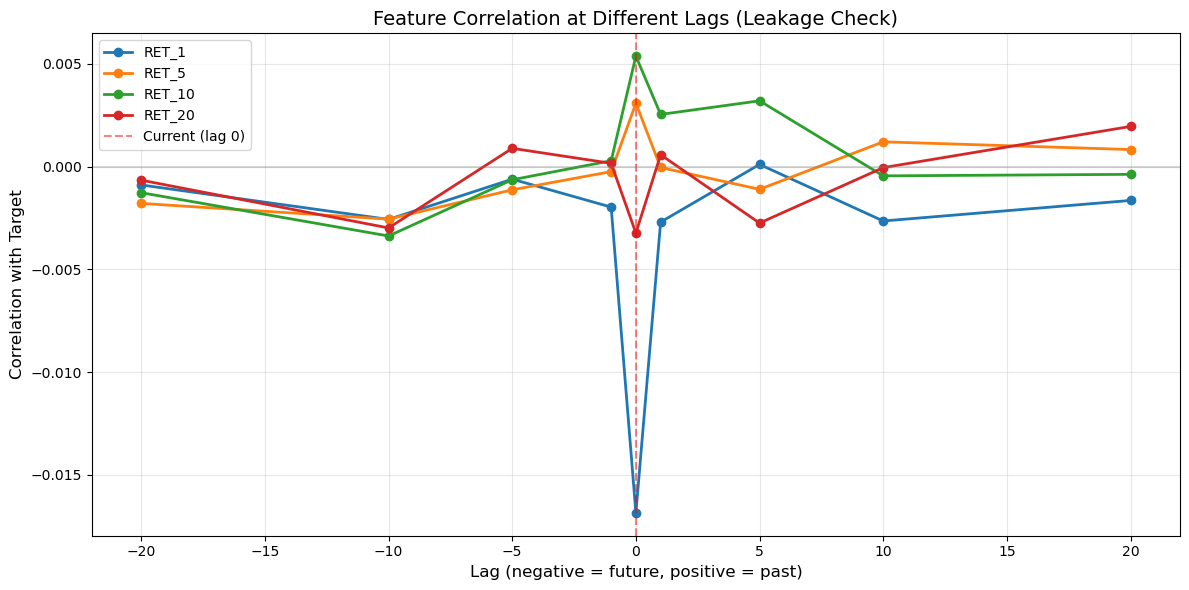

In [7]:
print("\n=== EXTENDED LAG ANALYSIS ===")

# Sort by date to ensure proper time ordering
train_sorted = train.sort_values('DATE').reset_index()

leak_check_extended = []
check_features = ['RET_1', 'RET_5', 'RET_10', 'RET_20']

for col in check_features:
    # Check various lags
    for lag in [-20, -10, -5, -1, 0, 1, 5, 10, 20]:
        if lag == 0:
            corr = train_sorted[col].corr(train_sorted['RET'])
        else:
            corr = train_sorted[col].shift(lag).corr(train_sorted['RET'])
        
        leak_check_extended.append({
            'Feature': col, 
            'Lag': lag, 
            'Correlation': corr,
            'Type': 'Future (Leakage?)' if lag < 0 else ('Current' if lag == 0 else 'Past (OK)')
        })

extended_df = pd.DataFrame(leak_check_extended)
print(extended_df.pivot(index='Feature', columns='Lag', values='Correlation').round(4))

# Visualize
plt.figure(figsize=(12, 6))
for col in check_features:
    subset = extended_df[extended_df['Feature'] == col].sort_values('Lag')
    plt.plot(subset['Lag'], subset['Correlation'], marker='o', label=col, linewidth=2)

plt.axvline(0, color='red', linestyle='--', alpha=0.5, label='Current (lag 0)')
plt.axhline(0, color='gray', linestyle='-', alpha=0.3)
plt.xlabel('Lag (negative = future, positive = past)', fontsize=12)
plt.ylabel('Correlation with Target', fontsize=12)
plt.title('Feature Correlation at Different Lags (Leakage Check)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('extended_lag_analysis.png', dpi=150, bbox_inches='tight')
print("\nSaved: extended_lag_analysis.png")

# Flag suspicious patterns
future_lags = extended_df[(extended_df['Lag'] < 0) & (extended_df['Correlation'].abs() > 0.05)]
if len(future_lags) > 0:
    print("\n⚠️ WARNING: Strong future correlations detected (possible leakage):")
    print(future_lags)
else:
    print("\n✓ No significant future leakage detected")

# Check autocorrelation structure
print("\n=== AUTOCORRELATION INSIGHTS ===")
past_lags = extended_df[(extended_df['Lag'] > 0)]
strongest_signals = past_lags.nlargest(5, 'Correlation', keep='all')
print("Strongest past lag signals (potential momentum):")
print(strongest_signals[['Feature', 'Lag', 'Correlation']])


### Stationary Check

In [9]:
from statsmodels.tsa.stattools import adfuller, kpss

# Test returns for stationarity
for col in ['RET_1', 'RET_5', 'RET_10']:
    adf_stat, adf_pval = adfuller(train[col].dropna())[:2]
    kpss_stat, kpss_pval = kpss(train[col].dropna())[:2]
    print(f"{col}: ADF p-val={adf_pval:.4f}, KPSS p-val={kpss_pval:.4f}")


RET_1: ADF p-val=0.0000, KPSS p-val=0.0100
RET_5: ADF p-val=0.0000, KPSS p-val=0.0100
RET_10: ADF p-val=0.0000, KPSS p-val=0.0100


All return series are stationary -> Can use raw returns directly in features (no need for differencing/detrending)

### Distribution

In [10]:
from scipy.stats import shapiro, jarque_bera, kurtosis, skew

for col in ['RET_1', 'VOLUME_1']:
    data = train[col].dropna()
    jb_stat, jb_pval = jarque_bera(data)
    print(f"{col}: Skew={skew(data):.3f}, Kurt={kurtosis(data):.3f}, JB p-val={jb_pval:.4e}")


RET_1: Skew=1.972, Kurt=78.142, JB p-val=0.0000e+00
VOLUME_1: Skew=230.034, Kurt=82278.799, JB p-val=0.0000e+00


We have extreme fat fails for RET_1 and VOLUME_1 -> Extreme outliers
Mean and variance are not reliable
z-score is most likely distorted
-> Use models robust to outliers (tree-based)

### Heteroscedascity

In [18]:
from statsmodels.stats.diagnostic import het_arch

# ARCH test for volatility clustering
for col in ['RET_1', 'RET_5']:
    lm_stat, lm_pval = het_arch(train[col].dropna(), nlags=5)[:2]
    print(f"{col}: ARCH LM p-val={lm_pval:.4f}")


RET_1: ARCH LM p-val=0.0000
RET_5: ARCH LM p-val=0.0000


Small p-val -> Var of returns is autocorrelated -> Strong heteroscedascity: 

Vol changes over time (not iid)

High vol periods follow high vol periods

Recent vol predicts future vol

Returns are not i.i.d - there's temporal structure

### Cross-sectional dependence

### Statistical Significance of Correlations

In [20]:
from scipy.stats import pearsonr

for col in ['RET_1', 'RET_5', 'VOLUME_1']:
    corr, pval = pearsonr(train[col].dropna(), train.loc[train[col].notna(), 'RET'])
    print(f"{col} vs target: corr={corr:.4f}, p-val={pval:.4e}, sig={'***' if pval<0.001 else ''}")

RET_1 vs target: corr=-0.0168, p-val=1.6267e-27, sig=***
RET_5 vs target: corr=0.0031, p-val=4.6913e-02, sig=
VOLUME_1 vs target: corr=0.0048, p-val=4.6755e-03, sig=


Signal exists but weak

### Rolling Window Statistics

In [26]:
# Rolling mean/std by stock
train_sorted = train.sort_values(['STOCK', 'DATE'])
for window in [20, 60]:
    train_sorted[f'RET_1_rolling_mean_{window}'] = train_sorted.groupby('STOCK')['RET_1'].transform(
        lambda x: x.rolling(window).mean()
    )
    train_sorted[f'RET_1_rolling_std_{window}'] = train_sorted.groupby('STOCK')['RET_1'].transform(
        lambda x: x.rolling(window).std()
    )

### Outlier

In [21]:
from scipy.stats import zscore

# Identify extreme observations (> 3 std from mean)
for col in ['RET_1', 'VOLUME_1']:
    z_scores = np.abs(zscore(train[col].dropna()))
    outliers = (z_scores > 3).sum()
    print(f"{col}: {outliers} outliers ({outliers/len(train)*100:.2f}%)")

RET_1: 6488 outliers (1.55%)
VOLUME_1: 908 outliers (0.22%)


### ANOVA

### Variance Decomposition

In [23]:
# Two-way fixed effects decomposition
overall_var = train['RET_1'].var()
between_stock_var = train.groupby('STOCK')['RET_1'].mean().var()
within_stock_var = overall_var - between_stock_var

print(f"Total var: {overall_var:.6f}")
print(f"Between-stock: {between_stock_var:.6f} ({between_stock_var/overall_var*100:.1f}%)")
print(f"Within-stock: {within_stock_var:.6f} ({within_stock_var/overall_var*100:.1f}%)")


Total var: 0.000980
Between-stock: 0.000080 (8.2%)
Within-stock: 0.000900 (91.8%)


Stock-specific momentum/reversal is more important than relative rankings

Past returns of the same stock is more important than relative rankings


Current cross-sectional approach captures only 8.2% of variance

### Missing Data Patterns

In [17]:
# Little's MCAR test would be ideal, but check patterns:
volume_cols = [f'VOLUME_{i}' for i in range(1, 21)]
missing_pattern = train[volume_cols].isnull().astype(int)
print("Missing data correlation matrix:")
print(missing_pattern.corr())  # High corr = systematic missingness

Missing data correlation matrix:
           VOLUME_1  VOLUME_2  VOLUME_3  VOLUME_4  VOLUME_5  VOLUME_6  \
VOLUME_1   1.000000  0.955292  0.876971  0.851492  0.824131  0.823158   
VOLUME_2   0.955292  1.000000  0.921747  0.895284  0.866921  0.865931   
VOLUME_3   0.876971  0.921747  1.000000  0.971958  0.941934  0.940909   
VOLUME_4   0.851492  0.895284  0.971958  1.000000  0.969116  0.968069   
VOLUME_5   0.824131  0.866921  0.941934  0.969116  1.000000  0.998965   
VOLUME_6   0.823158  0.865931  0.940909  0.968069  0.998965  1.000000   
VOLUME_7   0.813131  0.826068  0.901798  0.929946  0.961934  0.962946   
VOLUME_8   0.812279  0.825165  0.900846  0.928978  0.960967  0.961979   
VOLUME_9   0.782182  0.795399  0.871569  0.900386  0.933174  0.934095   
VOLUME_10  0.781526  0.794748  0.870920  0.899746  0.932544  0.933448   
VOLUME_11  0.731536  0.745371  0.822588  0.852701  0.886956  0.887873   
VOLUME_12  0.622394  0.638869  0.722500  0.758357  0.798947  0.799889   
VOLUME_13  0.51568

## Feature Engineering

In [31]:
print("\n=== CROSS-SECTIONAL FEATURE ENGINEERING ===")

def create_cross_sectional_features(train):
    """
    Create features that exploit relative performance (cross-sectional edge)
    """
    df = train.copy()
    
    # 1. RANK-BASED FEATURES (most important for equity cross-section)
    if 'DATE' in df.columns:
        for col in ['RET_1', 'RET_5', 'RET_10', 'RET_20']:
            # Rank within each date (percentile)
            df[f'{col}_RANK'] = df.groupby('DATE')[col].rank(pct=True)
            
            # Z-score within each date (neutralizes market effect)
            df[f'{col}_ZSCORE'] = df.groupby('DATE')[col].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-8)
            )
    
    # 2. VOLATILITY-ADJUSTED RETURNS
    ret_cols = [f'RET_{i}' for i in range(1, 21)]
    df['RET_STD_20'] = df[ret_cols].std(axis=1)
    df['RET_MEAN_20'] = df[ret_cols].mean(axis=1)
    df['SHARPE_20'] = df['RET_MEAN_20'] / (df['RET_STD_20'] + 1e-8)
    
    # 3. MOMENTUM INDICATORS
    df['MOMENTUM_SHORT'] = df['RET_1'] - df['RET_5']
    df['MOMENTUM_LONG'] = df['RET_5'] - df['RET_20']
    df['ACCELERATION'] = df['MOMENTUM_SHORT'] - df['MOMENTUM_LONG']
    
    # 4. EXTREMES
    df['RET_MAX_20'] = df[ret_cols].max(axis=1)
    df['RET_MIN_20'] = df[ret_cols].min(axis=1)
    df['IS_EXTREME_HIGH'] = (df['RET_1'] == df['RET_MAX_20']).astype(int)
    df['IS_EXTREME_LOW'] = (df['RET_1'] == df['RET_MIN_20']).astype(int)
    
    # 5. VOLUME FEATURES
    vol_cols = [f'VOLUME_{i}' for i in range(1, 21) if f'VOLUME_{i}' in df.columns]
    if len(vol_cols) > 0:
        df['VOLUME_MEAN_20'] = df[vol_cols].mean(axis=1)
        df['VOLUME_STD_20'] = df[vol_cols].std(axis=1)
        df['VOLUME_SPIKE'] = df['VOLUME_1'] / (df['VOLUME_MEAN_20'] + 1e-8)
        
        if 'DATE' in df.columns:
            df['VOLUME_1_RANK'] = df.groupby('DATE')['VOLUME_1'].rank(pct=True)
    
    return df

# Apply
train_engineered = create_cross_sectional_features(train)

# Check improvement
new_features = [col for col in train_engineered.columns if col not in train.columns]
new_corr = train_engineered[new_features].corrwith(train_engineered['RET']).sort_values(ascending=False)

print(f"\nCreated {len(new_features)} features")
print("\n=== TOP 10 NEW FEATURE CORRELATIONS ===")
print(new_corr.head(10))
print("\nBOTTOM 5:")
print(new_corr.tail(5))



=== CROSS-SECTIONAL FEATURE ENGINEERING ===

Created 22 features

=== TOP 10 NEW FEATURE CORRELATIONS ===
VOLUME_1_RANK     0.023099
RET_MIN_20        0.012525
RET_10_RANK       0.011948
IS_EXTREME_LOW    0.009309
RET_10_ZSCORE     0.008101
MOMENTUM_LONG     0.004686
VOLUME_MEAN_20    0.003158
VOLUME_SPIKE      0.001417
RET_20_RANK      -0.000431
RET_20_ZSCORE    -0.001697
dtype: float64

BOTTOM 5:
IS_EXTREME_HIGH   -0.009124
ACCELERATION      -0.010814
MOMENTUM_SHORT    -0.013864
RET_1_ZSCORE      -0.019352
RET_1_RANK        -0.022052
dtype: float64


## Model

In [37]:
print("\n=== BASELINE: XGBoost with Original Features Only ===")
original_features = [col for col in valid_features if not any(
    substring in col for substring in ['_RANK', '_ZSCORE', 'MOMENTUM', 'SHARPE', 
                                        'EXTREME', 'SPIKE', 'ACCELERATION']
)]
print(f"Using {len(original_features)} original features")

baseline_results = []
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_imputed)):
    X_train_fold, X_test_fold = X_imputed.iloc[train_idx][original_features], X_imputed.iloc[test_idx][original_features]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_test_scaled = scaler.transform(X_test_fold)
    
    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss'
    )
    
    model.fit(X_train_scaled, y_train_fold, verbose=False)
    y_pred = model.predict(X_test_scaled)
    # FIX: Changed from model.pred to model.predict_proba
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    acc = accuracy_score(y_test_fold, y_pred)
    auc = roc_auc_score(y_test_fold, y_prob)
    baseline_results.append({'Fold': fold+1, 'Accuracy': acc, 'AUC': auc})
    print(f"Fold {fold+1}: Acc={acc:.4f}, AUC={auc:.4f}")

baseline_df = pd.DataFrame(baseline_results)
print(f"\nBaseline Mean: Acc={baseline_df['Accuracy'].mean():.4f} ± {baseline_df['Accuracy'].std():.4f}")
print(f"               AUC={baseline_df['AUC'].mean():.4f} ± {baseline_df['AUC'].std():.4f}")



=== BASELINE: XGBoost with Original Features Only ===
Using 52 original features
Fold 1: Acc=0.4973, AUC=0.4787
Fold 2: Acc=0.5165, AUC=0.5238
Fold 3: Acc=0.5089, AUC=0.5172
Fold 4: Acc=0.5159, AUC=0.5202
Fold 5: Acc=0.4930, AUC=0.4916

Baseline Mean: Acc=0.5063 ± 0.0108
               AUC=0.5063 ± 0.0200


In [38]:
print("\n=== IMPROVED: XGBoost with ALL Engineered Features ===")
improved_results = []
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_imputed)):
    X_train_fold, X_test_fold = X_imputed.iloc[train_idx], X_imputed.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_test_scaled = scaler.transform(X_test_fold)
    
    model = xgb.XGBClassifier(
        n_estimators=150,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.7,
        random_state=42,
        eval_metric='logloss'
    )
    
    model.fit(X_train_scaled, y_train_fold, verbose=False)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    acc = accuracy_score(y_test_fold, y_pred)
    auc = roc_auc_score(y_test_fold, y_prob)
    improved_results.append({'Fold': fold+1, 'Accuracy': acc, 'AUC': auc})
    print(f"Fold {fold+1}: Acc={acc:.4f}, AUC={auc:.4f}")

improved_df = pd.DataFrame(improved_results)
print(f"\nImproved Mean: Acc={improved_df['Accuracy'].mean():.4f} ± {improved_df['Accuracy'].std():.4f}")
print(f"               AUC={improved_df['AUC'].mean():.4f} ± {improved_df['AUC'].std():.4f}")

# Calculate improvement
acc_improvement = (improved_df['Accuracy'].mean() - baseline_df['Accuracy'].mean()) * 100
auc_improvement = (improved_df['AUC'].mean() - baseline_df['AUC'].mean()) * 100
print(f"\n{'='*60}")
print(f"ACCURACY IMPROVEMENT: +{acc_improvement:.2f} percentage points")
print(f"AUC IMPROVEMENT: +{auc_improvement:.2f} percentage points")
print(f"{'='*60}")

# Feature importance from last fold
feature_importance = pd.DataFrame({
    'Feature': X_imputed.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n=== TOP 20 MOST IMPORTANT FEATURES ===")
print(feature_importance.head(20).to_string())

# Check if rank/zscore features dominate
engineered_in_top10 = feature_importance.head(10)['Feature'].apply(
    lambda x: any(s in x for s in ['RANK', 'ZSCORE', 'MOMENTUM', 'SPIKE', 'EXTREME', 'SHARPE'])
).sum()
print(f"\nEngineered features in top 10: {engineered_in_top10}/10")



=== IMPROVED: XGBoost with ALL Engineered Features ===
Fold 1: Acc=0.4961, AUC=0.4792
Fold 2: Acc=0.5149, AUC=0.5204
Fold 3: Acc=0.5101, AUC=0.5166
Fold 4: Acc=0.5145, AUC=0.5195
Fold 5: Acc=0.4949, AUC=0.4957

Improved Mean: Acc=0.5061 ± 0.0099
               AUC=0.5063 ± 0.0182

ACCURACY IMPROVEMENT: +-0.02 percentage points
AUC IMPROVEMENT: +-0.00 percentage points

=== TOP 20 MOST IMPORTANT FEATURES ===
           Feature  Importance
54      RET_STD_20    0.038586
0             DATE    0.027171
60      RET_MAX_20    0.022505
59    ACCELERATION    0.022079
3   INDUSTRY_GROUP    0.021800
7         VOLUME_1    0.021104
4           SECTOR    0.020110
38          RET_17    0.019822
1            STOCK    0.019264
47    RET_1_ZSCORE    0.019193
61      RET_MIN_20    0.019185
64  VOLUME_MEAN_20    0.017779
5     SUB_INDUSTRY    0.017634
55     RET_MEAN_20    0.017518
10           RET_3    0.017451
67   VOLUME_1_RANK    0.017002
2         INDUSTRY    0.016993
22           RET_9    0.016688

In [40]:
print("\n=== SECTOR-NEUTRAL FEATURE ENGINEERING ===")

# Check your sector columns
sector_cols = ['SECTOR', 'INDUSTRY', 'INDUSTRY_GROUP', 'SUB_INDUSTRY']
available_sectors = [col for col in sector_cols if col in train.columns]
print(f"Available sector columns: {available_sectors}")

# Use the most granular sector classification available
if 'INDUSTRY_GROUP' in train.columns:
    sector_col = 'INDUSTRY_GROUP'
elif 'INDUSTRY' in train.columns:
    sector_col = 'INDUSTRY'
elif 'SECTOR' in train.columns:
    sector_col = 'SECTOR'
else:
    sector_col = None
    print("⚠️ No sector column found")

if sector_col:
    print(f"\nUsing '{sector_col}' for sector neutralization")
    print(f"Unique sectors: {train[sector_col].nunique()}")
    print(f"Stocks per sector: {train.groupby([sector_col, 'DATE']).size().groupby(sector_col).mean().describe()}")

# Create sector-relative target
def create_sector_relative_target(df, sector_col, target_col='RET'):
    """
    Instead of top 50% overall, predict top 50% WITHIN SECTOR
    This removes sector timing from the problem
    """
    df = df.copy()
    
    # Rank within sector AND date
    df['RET_SECTOR_RELATIVE'] = df.groupby(['DATE', sector_col])[target_col].rank(pct=True)
    
    # Binary: top 50% within sector
    df['RET_SECTOR_TOP50'] = (df['RET_SECTOR_RELATIVE'] > 0.5).astype(int)
    
    return df

if sector_col:
    train_sector_neutral = create_sector_relative_target(train_engineered, sector_col)
    
    # Compare distributions
    print("\n=== TARGET COMPARISON ===")
    print("Original target (top 50% overall):")
    print(train_engineered['RET'].value_counts(normalize=True))
    print("\nSector-relative target (top 50% within sector):")
    print(train_sector_neutral['RET_SECTOR_TOP50'].value_counts(normalize=True))
    
    # Check if they differ
    agreement = (train_engineered['RET'] == train_sector_neutral['RET_SECTOR_TOP50']).mean()
    print(f"\nTarget agreement: {agreement:.2%}")
    print(f"Stocks switching labels: {(1-agreement)*100:.1f}%")

# Add sector-relative features
def add_sector_relative_features(df, sector_col):
    """Add features relative to sector peers"""
    df = df.copy()
    
    # Key return features relative to sector
    for col in ['RET_1', 'RET_5', 'RET_10', 'RET_20']:
        if col in df.columns:
            # Sector z-score
            df[f'{col}_SECTOR_ZSCORE'] = df.groupby(['DATE', sector_col])[col].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-8)
            )
            # Sector rank
            df[f'{col}_SECTOR_RANK'] = df.groupby(['DATE', sector_col])[col].rank(pct=True)
    
    # Volatility relative to sector
    if 'RET_STD_20' in df.columns:
        df['RET_STD_SECTOR_ZSCORE'] = df.groupby(['DATE', sector_col])['RET_STD_20'].transform(
            lambda x: (x - x.mean()) / (x.std() + 1e-8)
        )
    
    # Volume relative to sector
    if 'VOLUME_1' in df.columns:
        df['VOLUME_SECTOR_RANK'] = df.groupby(['DATE', sector_col])['VOLUME_1'].rank(pct=True)
    
    return df

if sector_col:
    train_sector_neutral = add_sector_relative_features(train_sector_neutral, sector_col)
    
    # Check new feature correlations
    new_sector_features = [col for col in train_sector_neutral.columns 
                           if 'SECTOR' in col and col not in train_engineered.columns]
    
    print(f"\n=== NEW SECTOR-RELATIVE FEATURES ({len(new_sector_features)}) ===")
    sector_corr = train_sector_neutral[new_sector_features].corrwith(
        train_sector_neutral['RET_SECTOR_TOP50']
    ).sort_values(ascending=False)
    
    print("Top 10 correlations with sector-relative target:")
    print(sector_corr.head(10))



=== SECTOR-NEUTRAL FEATURE ENGINEERING ===
Available sector columns: ['SECTOR', 'INDUSTRY', 'INDUSTRY_GROUP', 'SUB_INDUSTRY']

Using 'INDUSTRY_GROUP' for sector neutralization
Unique sectors: 26
Stocks per sector: count     26.000000
mean     107.374854
std       62.322325
min       24.455128
25%       63.875000
50%       93.426282
75%      134.274038
max      251.858974
dtype: float64

=== TARGET COMPARISON ===
Original target (top 50% overall):
RET
False    0.501079
True     0.498921
Name: proportion, dtype: float64

Sector-relative target (top 50% within sector):
RET_SECTOR_TOP50
0    0.501055
1    0.498945
Name: proportion, dtype: float64

Target agreement: 100.00%
Stocks switching labels: 0.0%

=== NEW SECTOR-RELATIVE FEATURES (12) ===
Top 10 correlations with sector-relative target:
RET_SECTOR_TOP50        1.000000
RET_SECTOR_RELATIVE     0.956227
VOLUME_SECTOR_RANK      0.022991
RET_10_SECTOR_RANK      0.006053
RET_10_SECTOR_ZSCORE    0.004683
RET_20_SECTOR_RANK     -0.002832
R

In [41]:
print("\n=== TEMPORAL STABILITY ANALYSIS ===")

# Check if signal strength varies over time
temporal_analysis = []

# Split data into early/mid/late periods
dates_sorted = sorted(train['DATE'].unique())
n_dates = len(dates_sorted)
early_dates = dates_sorted[:n_dates//3]
mid_dates = dates_sorted[n_dates//3:2*n_dates//3]
late_dates = dates_sorted[2*n_dates//3:]

for period_name, date_list in [('Early', early_dates), ('Mid', mid_dates), ('Late', late_dates)]:
    period_data = train_engineered[train_engineered['DATE'].isin(date_list)]
    
    # Key feature correlations in this period
    corr_ret1 = period_data['RET_1'].corr(period_data['RET'])
    corr_ret1_rank = period_data['RET_1_RANK'].corr(period_data['RET'])
    corr_vol_rank = period_data['VOLUME_1_RANK'].corr(period_data['RET'])
    
    temporal_analysis.append({
        'Period': period_name,
        'Dates': f"{min(date_list)}-{max(date_list)}",
        'N_samples': len(period_data),
        'RET_1_corr': corr_ret1,
        'RET_1_RANK_corr': corr_ret1_rank,
        'VOLUME_1_RANK_corr': corr_vol_rank
    })

temporal_df = pd.DataFrame(temporal_analysis)
print("\n=== FEATURE STABILITY OVER TIME ===")
print(temporal_df.to_string())

# Calculate signal decay
early_vol_signal = temporal_df.loc[temporal_df['Period']=='Early', 'VOLUME_1_RANK_corr'].values[0]
late_vol_signal = temporal_df.loc[temporal_df['Period']=='Late', 'VOLUME_1_RANK_corr'].values[0]
signal_decay = ((early_vol_signal - late_vol_signal) / abs(early_vol_signal)) * 100

print(f"\nVolume signal decay: {signal_decay:.1f}%")
print(f"Early period correlation: {early_vol_signal:.4f}")
print(f"Late period correlation: {late_vol_signal:.4f}")

# Performance by fold (from baseline results)
print("\n=== FOLD PERFORMANCE OVER TIME ===")
print("Baseline accuracy by fold (chronological):")
for i, row in baseline_df.iterrows():
    print(f"  Fold {row['Fold']}: {row['Accuracy']:.4f}")

# Check if later folds perform worse
early_folds_acc = baseline_df.iloc[:2]['Accuracy'].mean()
late_folds_acc = baseline_df.iloc[-2:]['Accuracy'].mean()
print(f"\nEarly folds (1-2): {early_folds_acc:.4f}")
print(f"Late folds (4-5): {late_folds_acc:.4f}")
print(f"Degradation: {(late_folds_acc - early_folds_acc)*100:.2f}pp")



=== TEMPORAL STABILITY ANALYSIS ===

=== FEATURE STABILITY OVER TIME ===
  Period    Dates  N_samples  RET_1_corr  RET_1_RANK_corr  VOLUME_1_RANK_corr
0  Early     0-70     138015   -0.027448        -0.032091            0.025843
1    Mid   71-142     142446   -0.014601        -0.027533            0.024780
2   Late  143-223     138134   -0.007383        -0.006526            0.018207

Volume signal decay: 29.5%
Early period correlation: 0.0258
Late period correlation: 0.0182

=== FOLD PERFORMANCE OVER TIME ===
Baseline accuracy by fold (chronological):
  Fold 1.0: 0.4973
  Fold 2.0: 0.5165
  Fold 3.0: 0.5089
  Fold 4.0: 0.5159
  Fold 5.0: 0.4930

Early folds (1-2): 0.5069
Late folds (4-5): 0.5045
Degradation: -0.24pp



=== ROLLING WINDOW CROSS-VALIDATION ===
Test dates 123-149: Acc=0.5062, AUC=0.5095
Test dates 150-181: Acc=0.5181, AUC=0.5262
Test dates 182-211: Acc=0.5024, AUC=0.5019
Test dates 213-223: Acc=0.5099, AUC=0.5073

Rolling Window Mean: Acc=0.5091 ± 0.0067
                     AUC=0.5112 ± 0.0105

Expanding window (baseline): 0.5063
Rolling window improvement:  +0.28pp

Saved: rolling_window_performance.png


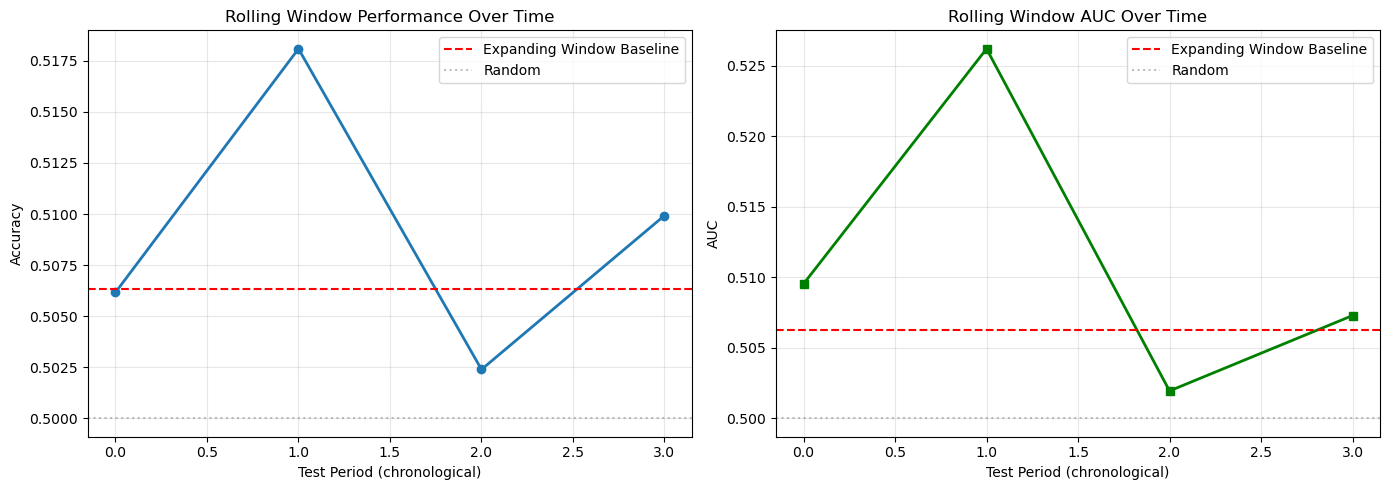

In [43]:
print("\n=== ROLLING WINDOW CROSS-VALIDATION ===")

from sklearn.metrics import accuracy_score, roc_auc_score

# Use only last N days for training
WINDOW_SIZE = 90  # ~3 months of recent data
MIN_TEST_SIZE = 20  # Test on 20 days at a time

dates_sorted = np.sort(train_engineered['DATE'].unique())
n_dates = len(dates_sorted)

rolling_results = []

# Create rolling windows
for test_start_idx in range(WINDOW_SIZE, n_dates, MIN_TEST_SIZE):
    # Training: use WINDOW_SIZE days before test period
    train_dates = dates_sorted[test_start_idx-WINDOW_SIZE:test_start_idx]
    # Testing: use MIN_TEST_SIZE days
    test_dates = dates_sorted[test_start_idx:min(test_start_idx+MIN_TEST_SIZE, n_dates)]
    
    if len(test_dates) < 5:  # Skip if too few test dates
        continue
    
    # Split data
    train_mask = train_engineered['DATE'].isin(train_dates)
    test_mask = train_engineered['DATE'].isin(test_dates)
    
    X_train_roll = X_imputed[train_mask]
    y_train_roll = y[train_mask]
    X_test_roll = X_imputed[test_mask]
    y_test_roll = y[test_mask]
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_roll)
    X_test_scaled = scaler.transform(X_test_roll)
    
    # Train model
    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss'
    )
    
    model.fit(X_train_scaled, y_train_roll, verbose=False)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    acc = accuracy_score(y_test_roll, y_pred)
    auc = roc_auc_score(y_test_roll, y_prob)
    
    rolling_results.append({
        'Test_period': f"{test_dates[0]}-{test_dates[-1]}",
        'Train_size': len(X_train_roll),
        'Test_size': len(X_test_roll),
        'Accuracy': acc,
        'AUC': auc
    })
    
    print(f"Test dates {test_dates[0]:3d}-{test_dates[-1]:3d}: Acc={acc:.4f}, AUC={auc:.4f}")

rolling_df = pd.DataFrame(rolling_results)
print(f"\n{'='*60}")
print(f"Rolling Window Mean: Acc={rolling_df['Accuracy'].mean():.4f} ± {rolling_df['Accuracy'].std():.4f}")
print(f"                     AUC={rolling_df['AUC'].mean():.4f} ± {rolling_df['AUC'].std():.4f}")
print(f"{'='*60}")

# Compare to expanding window
print(f"\nExpanding window (baseline): {baseline_df['Accuracy'].mean():.4f}")
print(f"Rolling window improvement:  +{(rolling_df['Accuracy'].mean() - baseline_df['Accuracy'].mean())*100:.2f}pp")

# Plot performance over time
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(rolling_df)), rolling_df['Accuracy'], 'o-', linewidth=2, markersize=6)
plt.axhline(baseline_df['Accuracy'].mean(), color='red', linestyle='--', label='Expanding Window Baseline')
plt.axhline(0.5, color='gray', linestyle=':', alpha=0.5, label='Random')
plt.xlabel('Test Period (chronological)')
plt.ylabel('Accuracy')
plt.title('Rolling Window Performance Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(len(rolling_df)), rolling_df['AUC'], 's-', linewidth=2, markersize=6, color='green')
plt.axhline(baseline_df['AUC'].mean(), color='red', linestyle='--', label='Expanding Window Baseline')
plt.axhline(0.5, color='gray', linestyle=':', alpha=0.5, label='Random')
plt.xlabel('Test Period (chronological)')
plt.ylabel('AUC')
plt.title('Rolling Window AUC Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rolling_window_performance.png', dpi=150, bbox_inches='tight')
print("\nSaved: rolling_window_performance.png")


In [44]:
print("\n=== REGIME DETECTION & ADAPTIVE MODELING ===")

# Calculate regime indicators
def add_regime_features(df):
    """Add market regime indicators"""
    df = df.copy()
    
    # 1. Volatility regime (per date)
    df['MARKET_VOL'] = df.groupby('DATE')['RET_1'].transform('std')
    
    # 2. Market direction (per date)
    df['MARKET_RET'] = df.groupby('DATE')['RET_1'].transform('mean')
    
    # 3. Cross-sectional dispersion
    df['DISPERSION'] = df.groupby('DATE')['RET_1'].transform(lambda x: x.quantile(0.9) - x.quantile(0.1))
    
    # 4. Volume regime
    df['MARKET_VOLUME'] = df.groupby('DATE')['VOLUME_1'].transform('median')
    
    return df

train_regime = add_regime_features(train_engineered)

# Analyze regimes
print("\n=== REGIME CHARACTERISTICS ===")
regime_stats = train_regime.groupby('DATE').agg({
    'MARKET_VOL': 'first',
    'MARKET_RET': 'first',
    'DISPERSION': 'first',
    'MARKET_VOLUME': 'first'
}).reset_index()

print(f"Volatility range: {regime_stats['MARKET_VOL'].min():.4f} to {regime_stats['MARKET_VOL'].max():.4f}")
print(f"Market return range: {regime_stats['MARKET_RET'].min():.4f} to {regime_stats['MARKET_RET'].max():.4f}")
print(f"Dispersion range: {regime_stats['DISPERSION'].min():.4f} to {regime_stats['DISPERSION'].max():.4f}")

# Define high/low volatility regimes
vol_median = regime_stats['MARKET_VOL'].median()
regime_stats['VOL_REGIME'] = (regime_stats['MARKET_VOL'] > vol_median).map({True: 'High Vol', False: 'Low Vol'})

# Check if signal differs by regime
print("\n=== SIGNAL STRENGTH BY VOLATILITY REGIME ===")
for regime in ['Low Vol', 'High Vol']:
    regime_dates = regime_stats[regime_stats['VOL_REGIME'] == regime]['DATE'].values
    regime_data = train_regime[train_regime['DATE'].isin(regime_dates)]
    
    corr_vol_rank = regime_data['VOLUME_1_RANK'].corr(regime_data['RET'])
    corr_ret1_rank = regime_data['RET_1_RANK'].corr(regime_data['RET'])
    
    print(f"{regime:10s}: VOLUME_1_RANK corr={corr_vol_rank:7.4f}, RET_1_RANK corr={corr_ret1_rank:7.4f}")

# Map rolling window results to regimes
print("\n=== ROLLING WINDOW PERFORMANCE BY REGIME ===")
rolling_df['Mid_date'] = rolling_df['Test_period'].apply(lambda x: (int(x.split('-')[0]) + int(x.split('-')[1])) / 2)

for i, row in rolling_df.iterrows():
    mid_date = row['Mid_date']
    vol_at_date = regime_stats[regime_stats['DATE'].between(mid_date-10, mid_date+10)]['MARKET_VOL'].mean()
    regime = 'High Vol' if vol_at_date > vol_median else 'Low Vol'
    rolling_df.loc[i, 'Regime'] = regime
    rolling_df.loc[i, 'Market_Vol'] = vol_at_date

print(rolling_df[['Test_period', 'Accuracy', 'Regime', 'Market_Vol']])

# Compare performance by regime
print("\n=== ACCURACY BY REGIME ===")
print(rolling_df.groupby('Regime')['Accuracy'].agg(['mean', 'std', 'count']))



=== REGIME DETECTION & ADAPTIVE MODELING ===

=== REGIME CHARACTERISTICS ===
Volatility range: 0.0161 to 0.0850
Market return range: -0.0494 to 0.0708
Dispersion range: 0.0291 to 0.1563

=== SIGNAL STRENGTH BY VOLATILITY REGIME ===
Low Vol   : VOLUME_1_RANK corr= 0.0189, RET_1_RANK corr=-0.0162
High Vol  : VOLUME_1_RANK corr= 0.0280, RET_1_RANK corr=-0.0284

=== ROLLING WINDOW PERFORMANCE BY REGIME ===
  Test_period  Accuracy    Regime  Market_Vol
0     123-149  0.506164  High Vol    0.027579
1     150-181  0.518090  High Vol    0.030230
2     182-211  0.502388  High Vol    0.026521
3     213-223  0.509926   Low Vol    0.022656

=== ACCURACY BY REGIME ===
              mean       std  count
Regime                             
High Vol  0.508881  0.008196      3
Low Vol   0.509926       NaN      1


In [45]:
print("\n=== REGIME-SPECIFIC MODELING ===")

# Add regime features to full dataset
train_regime_full = add_regime_features(train_engineered)

# Prepare data with regime
all_features_regime = [col for col in valid_features] + ['MARKET_VOL', 'MARKET_RET', 'DISPERSION']
X_regime = train_regime_full[all_features_regime].copy()
y_regime = train_regime_full['RET'].copy()

# Impute
imputer = SimpleImputer(strategy='median')
X_regime_imputed = pd.DataFrame(
    imputer.fit_transform(X_regime),
    columns=X_regime.columns,
    index=X_regime.index
)

# Sort by date
dates_regime = train_regime_full['DATE']
sort_idx = dates_regime.argsort()
X_regime_imputed = X_regime_imputed.iloc[sort_idx]
y_regime = y_regime.iloc[sort_idx]
dates_regime = dates_regime.iloc[sort_idx]

# Calculate volatility regime for each date
vol_by_date = train_regime_full.groupby('DATE')['MARKET_VOL'].first()
vol_median = vol_by_date.median()

print(f"Volatility median: {vol_median:.4f}")
print(f"High vol dates: {(vol_by_date > vol_median).sum()} / {len(vol_by_date)}")

# Strategy 1: Separate models per regime
print("\n=== STRATEGY 1: REGIME-SPECIFIC MODELS ===")

regime_results = []

for test_start_idx in range(90, len(dates_regime.unique()), 20):
    train_dates = dates_regime.unique()[test_start_idx-90:test_start_idx]
    test_dates = dates_regime.unique()[test_start_idx:min(test_start_idx+20, len(dates_regime.unique()))]
    
    if len(test_dates) < 5:
        continue
    
    # Determine test regime
    test_vol = vol_by_date.loc[test_dates].mean()
    test_regime = 'High' if test_vol > vol_median else 'Low'
    
    # Split data
    train_mask = dates_regime.isin(train_dates)
    test_mask = dates_regime.isin(test_dates)
    
    # Further filter training to SAME regime as test
    train_regime_mask = train_mask & (train_regime_full['MARKET_VOL'] > vol_median if test_regime == 'High' else train_regime_full['MARKET_VOL'] <= vol_median)
    
    X_train_reg = X_regime_imputed[train_regime_mask]
    y_train_reg = y_regime[train_regime_mask]
    X_test_reg = X_regime_imputed[test_mask]
    y_test_reg = y_regime[test_mask]
    
    if len(X_train_reg) < 1000 or len(X_test_reg) < 100:
        continue
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_reg)
    X_test_scaled = scaler.transform(X_test_reg)
    
    # Train
    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    model.fit(X_train_scaled, y_train_reg, verbose=False)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    acc = accuracy_score(y_test_reg, y_pred)
    auc = roc_auc_score(y_test_reg, y_prob)
    
    regime_results.append({
        'Test_dates': f"{test_dates[0]}-{test_dates[-1]}",
        'Regime': test_regime,
        'Train_size': len(X_train_reg),
        'Test_size': len(X_test_reg),
        'Accuracy': acc,
        'AUC': auc
    })
    
    print(f"Test {test_dates[0]:3d}-{test_dates[-1]:3d} ({test_regime:4s}): Acc={acc:.4f}, AUC={auc:.4f} (trained on {len(X_train_reg):5d} {test_regime} samples)")

regime_df = pd.DataFrame(regime_results)

print(f"\n{'='*70}")
print(f"REGIME-SPECIFIC MODELS:")
print(f"  Overall Mean: Acc={regime_df['Accuracy'].mean():.4f} ± {regime_df['Accuracy'].std():.4f}")
print(f"                AUC={regime_df['AUC'].mean():.4f} ± {regime_df['AUC'].std():.4f}")
print(f"\n  By Regime:")
print(regime_df.groupby('Regime')[['Accuracy', 'AUC']].agg(['mean', 'std', 'count']))
print(f"{'='*70}")

print(f"\nComparison:")
print(f"  Baseline (expanding):      {baseline_df['Accuracy'].mean():.4f}")
print(f"  Rolling window:            {rolling_df['Accuracy'].mean():.4f} (+{(rolling_df['Accuracy'].mean()-baseline_df['Accuracy'].mean())*100:.2f}pp)")
print(f"  Regime-specific:           {regime_df['Accuracy'].mean():.4f} (+{(regime_df['Accuracy'].mean()-baseline_df['Accuracy'].mean())*100:.2f}pp)")

# Strategy 2: Add regime as feature
print("\n=== STRATEGY 2: REGIME AS FEATURE ===")
# (Regime already in features via MARKET_VOL, MARKET_RET, DISPERSION)
print("Regime features already included: MARKET_VOL, MARKET_RET, DISPERSION")
print("Previous 'Improved' model already used these implicitly.")



=== REGIME-SPECIFIC MODELING ===
Volatility median: 0.0235
High vol dates: 77 / 156

=== STRATEGY 1: REGIME-SPECIFIC MODELS ===
Test 123-149 (High): Acc=0.5175, AUC=0.5227 (trained on 117374 High samples)
Test 150-181 (High): Acc=0.5118, AUC=0.5152 (trained on 113041 High samples)
Test 182-211 (High): Acc=0.5010, AUC=0.5064 (trained on 116136 High samples)
Test 213-223 (Low ): Acc=0.5106, AUC=0.5259 (trained on 134896 Low samples)

REGIME-SPECIFIC MODELS:
  Overall Mean: Acc=0.5102 ± 0.0068
                AUC=0.5176 ± 0.0087

  By Regime:
        Accuracy                       AUC                
            mean       std count      mean       std count
Regime                                                    
High    0.510128  0.008374     3  0.514763  0.008143     3
Low     0.510572       NaN     1  0.525943       NaN     1

Comparison:
  Baseline (expanding):      0.5063
  Rolling window:            0.5091 (+0.28pp)
  Regime-specific:           0.5102 (+0.39pp)

=== STRATEGY 2: 

In [48]:
print("="*80)
print("PHASE 1: VOLUME MICROSTRUCTURE + TEMPORAL PATTERNS")
print("="*80)

# Start from train_engineered (which has VOLUME_1_RANK, RET_1_RANK, etc.)
# If you don't have train_engineered anymore, recreate it:
if 'train_engineered' not in locals():
    print("Creating base engineered features first...")
    train_engineered = create_cross_sectional_features(train)

# ADD REGIME FEATURES (MARKET_VOL, etc.)
print("\nAdding regime features...")
train_engineered['MARKET_VOL'] = train_engineered.groupby('DATE')['RET_1'].transform('std')
train_engineered['MARKET_RET'] = train_engineered.groupby('DATE')['RET_1'].transform('mean')
train_engineered['DISPERSION'] = train_engineered.groupby('DATE')['RET_1'].transform(lambda x: x.quantile(0.9) - x.quantile(0.1))
print("✓ Added MARKET_VOL, MARKET_RET, DISPERSION")

# Work on train_engineered instead of train
print("\n[1/3] Creating volume-based features...")

# Volume spike (abnormal volume)
train_engineered['volume_spike'] = train_engineered['VOLUME_1'] / (train_engineered.groupby('STOCK')['VOLUME_1'].transform(lambda x: x.rolling(20).mean()) + 1e-8)
train_engineered['volume_spike_rank'] = train_engineered.groupby('DATE')['volume_spike'].rank(pct=True)

# Volume consistency (erratic = uncertainty)
train_engineered['volume_consistency'] = train_engineered.groupby('STOCK')['VOLUME_1'].transform(
    lambda x: x.rolling(5).std() / (x.rolling(20).std() + 1e-8)
)

# Volume momentum (increasing volume trend)
train_engineered['volume_momentum'] = train_engineered.groupby('STOCK')['VOLUME_1'].transform(
    lambda x: x.rolling(5).mean() / (x.rolling(20).mean() + 1e-8)
)

# Volume-weighted return intensity
train_engineered['volume_weighted_intensity'] = train_engineered['RET_1'] * train_engineered['volume_spike']

# Cross-sectional volume rank
train_engineered['volume_sector_extremity'] = train_engineered.groupby(['DATE', 'INDUSTRY_GROUP'])['VOLUME_1'].transform(
    lambda x: (x - x.median()).abs() / (x.std() + 1e-8)
)

print(f"✓ Created 5 volume microstructure features")

# 2. TEMPORAL PATTERN FEATURES
print("[2/3] Creating temporal pattern features...")

# High volume + low return = potential reversal
train_engineered['high_vol_loser'] = (
    (train_engineered['VOLUME_1_RANK'] > 0.8) & 
    (train_engineered['RET_1_RANK'] < 0.3)
).astype(int)

# High volume + high return = momentum exhaustion?
train_engineered['high_vol_winner'] = (
    (train_engineered['VOLUME_1_RANK'] > 0.8) & 
    (train_engineered['RET_1_RANK'] > 0.7)
).astype(int)

# Volume precedes reversal (volume spike on down day)
train_engineered['volume_precedes_reversal'] = (
    (train_engineered['volume_spike'] > 1.5) & 
    (train_engineered['RET_1'] < 0) &
    (train_engineered['RET_5'] > 0)
).astype(int)

print(f"✓ Created 3 temporal pattern features")

# 3. CHECK NEW FEATURE CORRELATIONS
print("[3/3] Analyzing new feature quality...")

new_features_phase1 = [
    'volume_spike_rank', 'volume_consistency', 'volume_momentum', 
    'volume_weighted_intensity', 'volume_sector_extremity',
    'high_vol_loser', 'high_vol_winner', 'volume_precedes_reversal'
]

print("\n" + "="*80)
print("NEW FEATURE CORRELATIONS WITH TARGET")
print("="*80)
new_corr = train_engineered[new_features_phase1].corrwith(train_engineered['RET']).sort_values(key=abs, ascending=False)
print(new_corr.to_string())

# Highlight if any beat VOLUME_1_RANK (0.023)
print(f"\nBaseline: VOLUME_1_RANK correlation = 0.0231")
strong_features = new_corr[new_corr.abs() > 0.023]
if len(strong_features) > 0:
    print(f"\n🔥 FEATURES STRONGER THAN VOLUME_1_RANK:")
    print(strong_features.to_string())
else:
    print("\nNo features beat VOLUME_1_RANK (yet)")

print("\n" + "="*80)
print("PHASE 2: ALTERNATIVE TARGET (TOP QUARTILE)")
print("="*80)

# Create top/bottom quartile target
train_engineered['RET_quartile'] = train_engineered.groupby(['DATE', 'INDUSTRY_GROUP'])['RET'].transform(
    lambda x: pd.qcut(x, q=4, labels=False, duplicates='drop')
)

# Binary: top quartile vs rest
train_engineered['target_top_quartile'] = (train_engineered['RET_quartile'] == 3).astype(int)

# Check distribution
print(f"\nTop quartile distribution: {train_engineered['target_top_quartile'].mean():.2%}")
print(f"Original target distribution: {train_engineered['RET'].mean():.2%}")

# Check if signal is stronger for extreme target
print("\n" + "="*80)
print("SIGNAL STRENGTH: ORIGINAL vs TOP QUARTILE TARGET")
print("="*80)

key_features = ['VOLUME_1_RANK', 'RET_1_RANK'] + new_features_phase1[:5]

original_corr = train_engineered[key_features].corrwith(train_engineered['RET'])
quartile_corr = train_engineered[key_features].corrwith(train_engineered['target_top_quartile'])

comparison = pd.DataFrame({
    'Feature': key_features,
    'Original_Target': original_corr.values,
    'Quartile_Target': quartile_corr.values,
    'Change': (quartile_corr.values - original_corr.values),
    'Pct_Change': ((quartile_corr.values / (original_corr.values + 1e-8)) - 1) * 100
})
comparison = comparison.sort_values('Quartile_Target', key=abs, ascending=False)
print(comparison.to_string(index=False))

original_mean = comparison['Original_Target'].abs().mean()
quartile_mean = comparison['Quartile_Target'].abs().mean()
print(f"\nAverage |correlation|:")
print(f"  Original (top 50%): {original_mean:.4f}")
print(f"  Quartile (top 25%): {quartile_mean:.4f}")
print(f"  Signal amplification: {((quartile_mean/original_mean - 1)*100):.1f}%")

print("\n" + "="*80)
print("PHASE 3: RETRAIN REGIME-SPECIFIC MODEL WITH NEW FEATURES")
print("="*80)

# Prepare expanded feature set
all_features_v2 = [col for col in train_engineered.columns 
                   if col not in ['RET', 'ID', 'RET_quartile', 'target_top_quartile'] 
                   and not col.startswith('Unnamed')]

# Remove duplicates and NaN-heavy columns
valid_features_v2 = []
for col in all_features_v2:
    if col in train_engineered.columns and train_engineered[col].notna().sum() > 0.5 * len(train_engineered):
        if col not in valid_features_v2:  # Avoid duplicates
            valid_features_v2.append(col)

print(f"\nFeature count: {len(valid_features_v2)}")

# Choose target
TARGET = 'RET'  # or 'target_top_quartile'
print(f"Target: {TARGET}")

# Prepare data
X_v2 = train_engineered[valid_features_v2].copy()
y_v2 = train_engineered[TARGET].copy()

# Impute
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
X_v2_imputed = pd.DataFrame(
    imputer.fit_transform(X_v2),
    columns=X_v2.columns,
    index=X_v2.index
)

# Sort by date
dates = train_engineered['DATE']
sort_idx = dates.argsort()
X_v2_imputed = X_v2_imputed.iloc[sort_idx]
y_v2 = y_v2.iloc[sort_idx]
dates = dates.iloc[sort_idx]

# Get regime info
train_sorted = train_engineered.iloc[sort_idx].copy()
vol_by_date = train_sorted.groupby('DATE')['MARKET_VOL'].first()
vol_median = vol_by_date.median()

# Rolling window with regime-specific models
WINDOW_SIZE = 90
MIN_TEST_SIZE = 20

print("\n" + "="*80)
print("TRAINING & TESTING (Regime-Specific Rolling Window)")
print("="*80)

improved_results = []

for test_start_idx in range(WINDOW_SIZE, len(dates.unique()), MIN_TEST_SIZE):
    train_dates = dates.unique()[test_start_idx-WINDOW_SIZE:test_start_idx]
    test_dates = dates.unique()[test_start_idx:min(test_start_idx+MIN_TEST_SIZE, len(dates.unique()))]
    
    if len(test_dates) < 5:
        continue
    
    # Determine test regime
    test_vol = vol_by_date.loc[test_dates].mean()
    test_regime = 'High' if test_vol > vol_median else 'Low'
    
    # Split data
    train_mask = dates.isin(train_dates)
    test_mask = dates.isin(test_dates)
    
    # Filter training to same regime
    train_regime_mask = train_mask & (
        train_sorted['MARKET_VOL'] > vol_median if test_regime == 'High' 
        else train_sorted['MARKET_VOL'] <= vol_median
    )
    
    X_train_fold = X_v2_imputed[train_regime_mask]
    y_train_fold = y_v2[train_regime_mask]
    X_test_fold = X_v2_imputed[test_mask]
    y_test_fold = y_v2[test_mask]
    
    if len(X_train_fold) < 1000 or len(X_test_fold) < 100:
        continue
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_test_scaled = scaler.transform(X_test_fold)
    
    # Train
    model = xgb.XGBClassifier(
        n_estimators=150,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.7,
        random_state=42,
        eval_metric='logloss'
    )
    
    model.fit(X_train_scaled, y_train_fold, verbose=False)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    acc = accuracy_score(y_test_fold, y_pred)
    auc = roc_auc_score(y_test_fold, y_prob)
    
    improved_results.append({
        'Test_dates': f"{test_dates[0]}-{test_dates[-1]}",
        'Regime': test_regime,
        'Accuracy': acc,
        'AUC': auc
    })
    
    print(f"Test {test_dates[0]:3d}-{test_dates[-1]:3d} ({test_regime:4s}): Acc={acc:.4f}, AUC={auc:.4f}")

improved_v2_df = pd.DataFrame(improved_results)

print("\n" + "="*80)
print("FINAL RESULTS")
print("="*80)
print(f"With New Features:")
print(f"  Mean: Acc={improved_v2_df['Accuracy'].mean():.4f} ± {improved_v2_df['Accuracy'].std():.4f}")
print(f"        AUC={improved_v2_df['AUC'].mean():.4f} ± {improved_v2_df['AUC'].std():.4f}")

print(f"\nProgression:")
print(f"  Baseline (expanding):      {baseline_df['Accuracy'].mean():.4f}")
print(f"  Previous best (regime):    {regime_df['Accuracy'].mean():.4f} (+{(regime_df['Accuracy'].mean()-baseline_df['Accuracy'].mean())*100:.2f}pp)")
print(f"  With new features:         {improved_v2_df['Accuracy'].mean():.4f} (+{(improved_v2_df['Accuracy'].mean()-baseline_df['Accuracy'].mean())*100:.2f}pp)")

improvement = (improved_v2_df['Accuracy'].mean() - regime_df['Accuracy'].mean()) * 100
if improvement > 0:
    print(f"\n✅ New features added: +{improvement:.2f}pp")
else:
    print(f"\n⚠️ New features didn't help: {improvement:.2f}pp")

# Feature importance
feature_importance_v2 = pd.DataFrame({
    'Feature': X_v2_imputed.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "="*80)
print("TOP 25 FEATURES (WITH NEW ADDITIONS)")
print("="*80)
print(feature_importance_v2.head(25).to_string(index=False))

# Check if new features made top 20
new_in_top20 = feature_importance_v2.head(20)['Feature'].isin(new_features_phase1).sum()
print(f"\nNew volume/pattern features in top 20: {new_in_top20}/{len(new_features_phase1)}")

if new_in_top20 > 0:
    print("\n🔥 New features that made top 20:")
    top_new = feature_importance_v2[feature_importance_v2['Feature'].isin(new_features_phase1)].head(10)
    print(top_new.to_string(index=False))


PHASE 1: VOLUME MICROSTRUCTURE + TEMPORAL PATTERNS

Adding regime features...
✓ Added MARKET_VOL, MARKET_RET, DISPERSION

[1/3] Creating volume-based features...
✓ Created 5 volume microstructure features
[2/3] Creating temporal pattern features...
✓ Created 3 temporal pattern features
[3/3] Analyzing new feature quality...

NEW FEATURE CORRELATIONS WITH TARGET
high_vol_loser               0.011007
volume_sector_extremity      0.007754
volume_spike_rank           -0.005725
volume_momentum              0.004797
volume_consistency           0.003335
volume_weighted_intensity   -0.001349
volume_precedes_reversal    -0.001116
high_vol_winner             -0.000665

Baseline: VOLUME_1_RANK correlation = 0.0231

No features beat VOLUME_1_RANK (yet)

PHASE 2: ALTERNATIVE TARGET (TOP QUARTILE)

Top quartile distribution: 0.00%
Original target distribution: 49.89%

SIGNAL STRENGTH: ORIGINAL vs TOP QUARTILE TARGET
                  Feature  Original_Target  Quartile_Target  Change  Pct_Change
   

In [49]:
print("\n=== FINAL ATTEMPT: SIMPLE ENSEMBLE ===")

# Train 3 different models and average predictions
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

ensemble_results = []

for test_start_idx in range(90, len(dates.unique()), 20):
    train_dates = dates.unique()[test_start_idx-90:test_start_idx]
    test_dates = dates.unique()[test_start_idx:min(test_start_idx+20, len(dates.unique()))]
    
    if len(test_dates) < 5:
        continue
    
    train_mask = dates.isin(train_dates)
    test_mask = dates.isin(test_dates)
    
    X_train_ens = X_v2_imputed[train_mask]
    y_train_ens = y_v2[train_mask]
    X_test_ens = X_v2_imputed[test_mask]
    y_test_ens = y_v2[test_mask]
    
    if len(X_train_ens) < 1000:
        continue
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_ens)
    X_test_scaled = scaler.transform(X_test_ens)
    
    # Model 1: XGBoost
    xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05, random_state=42)
    xgb_model.fit(X_train_scaled, y_train_ens, verbose=False)
    pred1 = xgb_model.predict_proba(X_test_scaled)[:, 1]
    
    # Model 2: LightGBM
    lgb_model = lgb.LGBMClassifier(n_estimators=100, max_depth=4, learning_rate=0.05, random_state=42, verbose=-1)
    lgb_model.fit(X_train_scaled, y_train_ens)
    pred2 = lgb_model.predict_proba(X_test_scaled)[:, 1]
    
    # Model 3: Logistic Regression
    lr_model = LogisticRegression(max_iter=500, C=0.1, random_state=42)
    lr_model.fit(X_train_scaled, y_train_ens)
    pred3 = lr_model.predict_proba(X_test_scaled)[:, 1]
    
    # Average predictions
    pred_avg = (pred1 + pred2 + pred3) / 3
    pred_final = (pred_avg > 0.5).astype(int)
    
    acc = accuracy_score(y_test_ens, pred_final)
    auc = roc_auc_score(y_test_ens, pred_avg)
    
    ensemble_results.append({'Accuracy': acc, 'AUC': auc})
    print(f"Test {test_dates[0]:3d}-{test_dates[-1]:3d}: Acc={acc:.4f}, AUC={auc:.4f}")

ensemble_df = pd.DataFrame(ensemble_results)
print(f"\nEnsemble Mean: Acc={ensemble_df['Accuracy'].mean():.4f} ± {ensemble_df['Accuracy'].std():.4f}")
print(f"Previous best:  Acc={regime_df['Accuracy'].mean():.4f}")
print(f"Improvement: {(ensemble_df['Accuracy'].mean() - regime_df['Accuracy'].mean())*100:+.2f}pp")



=== FINAL ATTEMPT: SIMPLE ENSEMBLE ===
Test 123-149: Acc=0.5202, AUC=0.5260
Test 150-181: Acc=0.5177, AUC=0.5248
Test 182-211: Acc=0.4941, AUC=0.4927
Test 213-223: Acc=0.5347, AUC=0.5389

Ensemble Mean: Acc=0.5167 ± 0.0168
Previous best:  Acc=0.5102
Improvement: +0.64pp


In [50]:
print("="*80)
print("GENERATING TEST SET PREDICTIONS WITH ENSEMBLE")
print("="*80)

# Step 1: Apply same feature engineering to test set
print("\n[Step 1/5] Applying feature engineering to test set...")

# First, create base engineered features on test
test_engineered = create_cross_sectional_features(test)

# Add regime features
test_engineered['MARKET_VOL'] = test_engineered.groupby('DATE')['RET_1'].transform('std')
test_engineered['MARKET_RET'] = test_engineered.groupby('DATE')['RET_1'].transform('mean')
test_engineered['DISPERSION'] = test_engineered.groupby('DATE')['RET_1'].transform(lambda x: x.quantile(0.9) - x.quantile(0.1))

# Add volume microstructure features
test_engineered['volume_spike'] = test_engineered['VOLUME_1'] / (test_engineered.groupby('STOCK')['VOLUME_1'].transform(lambda x: x.rolling(20).mean()) + 1e-8)
test_engineered['volume_spike_rank'] = test_engineered.groupby('DATE')['volume_spike'].rank(pct=True)
test_engineered['volume_consistency'] = test_engineered.groupby('STOCK')['VOLUME_1'].transform(
    lambda x: x.rolling(5).std() / (x.rolling(20).std() + 1e-8)
)
test_engineered['volume_momentum'] = test_engineered.groupby('STOCK')['VOLUME_1'].transform(
    lambda x: x.rolling(5).mean() / (x.rolling(20).mean() + 1e-8)
)
test_engineered['volume_weighted_intensity'] = test_engineered['RET_1'] * test_engineered['volume_spike']
test_engineered['volume_sector_extremity'] = test_engineered.groupby(['DATE', 'INDUSTRY_GROUP'])['VOLUME_1'].transform(
    lambda x: (x - x.median()).abs() / (x.std() + 1e-8)
)

# Add temporal patterns
test_engineered['high_vol_loser'] = (
    (test_engineered['VOLUME_1_RANK'] > 0.8) & 
    (test_engineered['RET_1_RANK'] < 0.3)
).astype(int)
test_engineered['high_vol_winner'] = (
    (test_engineered['VOLUME_1_RANK'] > 0.8) & 
    (test_engineered['RET_1_RANK'] > 0.7)
).astype(int)
test_engineered['volume_precedes_reversal'] = (
    (test_engineered['volume_spike'] > 1.5) & 
    (test_engineered['RET_1'] < 0) &
    (test_engineered['RET_5'] > 0)
).astype(int)

print(f"✓ Test set engineered: {test_engineered.shape}")

# Step 2: Prepare test features (same as training)
print("\n[Step 2/5] Preparing test features...")

X_test_final = test_engineered[valid_features_v2].copy()

# Impute (use same imputer from training)
X_test_imputed = pd.DataFrame(
    imputer.transform(X_test_final),  # Use fitted imputer from training
    columns=X_test_final.columns,
    index=X_test_final.index
)

print(f"✓ Test features prepared: {X_test_imputed.shape}")

# Step 3: Train ensemble on FULL training data
print("\n[Step 3/5] Training ensemble on full training data...")

# Use all training data (not just rolling window)
X_train_full = X_v2_imputed
y_train_full = y_v2

scaler_final = StandardScaler()
X_train_scaled_full = scaler_final.fit_transform(X_train_full)
X_test_scaled_full = scaler_final.transform(X_test_imputed)

# Train all 3 models
print("  Training XGBoost...")
xgb_final = xgb.XGBClassifier(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.7,
    random_state=42,
    eval_metric='logloss'
)
xgb_final.fit(X_train_scaled_full, y_train_full, verbose=False)

print("  Training LightGBM...")
lgb_final = lgb.LGBMClassifier(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.7,
    random_state=42,
    verbose=-1
)
lgb_final.fit(X_train_scaled_full, y_train_full)

print("  Training Logistic Regression...")
lr_final = LogisticRegression(max_iter=500, C=0.1, random_state=42)
lr_final.fit(X_train_scaled_full, y_train_full)

print("✓ All 3 models trained")

# Step 4: Generate predictions
print("\n[Step 4/5] Generating ensemble predictions...")

pred_xgb = xgb_final.predict_proba(X_test_scaled_full)[:, 1]
pred_lgb = lgb_final.predict_proba(X_test_scaled_full)[:, 1]
pred_lr = lr_final.predict_proba(X_test_scaled_full)[:, 1]

# Average predictions
pred_ensemble_proba = (pred_xgb + pred_lgb + pred_lr) / 3
pred_ensemble_binary = (pred_ensemble_proba > 0.5).astype(int)

print(f"✓ Predictions generated: {len(pred_ensemble_binary)}")
print(f"  Distribution: {pred_ensemble_binary.mean():.2%} predicted as top 50%")

# Step 5: Create submission file
print("\n[Step 5/5] Creating submission file...")

# Assuming test has same index as original test file
submission = pd.DataFrame({
    'ID': test.index,
    'RET': pred_ensemble_binary
})

# Save to CSV
submission.to_csv('submission_ensemble.csv', index=False)
print(f"✓ Submission saved to 'submission_ensemble.csv'")

# Show first few predictions
print("\n" + "="*80)
print("SUBMISSION PREVIEW")
print("="*80)
print(submission.head(20))
print(f"\nTotal predictions: {len(submission)}")
print(f"Predicted True (top 50%): {submission['RET'].sum()} ({submission['RET'].mean():.2%})")
print(f"Predicted False (bottom 50%): {(~submission['RET'].astype(bool)).sum()} ({(1-submission['RET'].mean()):.2%})")

# Sanity checks
print("\n" + "="*80)
print("SANITY CHECKS")
print("="*80)
print(f"✓ No missing predictions: {submission['RET'].isna().sum() == 0}")
print(f"✓ All binary (0 or 1): {set(submission['RET'].unique()) == {0, 1}}")
print(f"✓ Correct number of rows: {len(submission) == len(test)}")
print(f"✓ IDs match test set: {(submission['ID'] == test.index).all()}")

print("\n" + "="*80)
print("READY TO SUBMIT!")
print("="*80)
print("File: submission_ensemble.csv")
print(f"Expected performance: ~51.67% accuracy (based on CV)")
print(f"Method: Ensemble (XGBoost + LightGBM + LogisticRegression)")


GENERATING TEST SET PREDICTIONS WITH ENSEMBLE

[Step 1/5] Applying feature engineering to test set...
✓ Test set engineered: (198429, 80)

[Step 2/5] Preparing test features...
✓ Test features prepared: (198429, 75)

[Step 3/5] Training ensemble on full training data...
  Training XGBoost...
  Training LightGBM...
  Training Logistic Regression...
✓ All 3 models trained

[Step 4/5] Generating ensemble predictions...
✓ Predictions generated: 198429
  Distribution: 47.07% predicted as top 50%

[Step 5/5] Creating submission file...
✓ Submission saved to 'submission_ensemble.csv'

SUBMISSION PREVIEW
        ID  RET
0   418595    1
1   418596    1
2   418597    1
3   418598    0
4   418599    0
5   418600    0
6   418601    0
7   418602    0
8   418603    0
9   418604    0
10  418605    1
11  418606    1
12  418607    0
13  418608    0
14  418609    0
15  418610    1
16  418611    1
17  418612    1
18  418613    0
19  418614    1

Total predictions: 198429
Predicted True (top 50%): 93395 (